# 6. Plot All Results

gg-napari-env

In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from skimage.measure import regionprops
from napari_czifile2 import napari_get_reader
from skimage import io
import os 
import pandas as pd
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")

In [2]:
def plot_2_channels(results, c1, c2, c1_name, c2_name, c1_color, c2_color, coordinates, 
                    image, metadata, all_rois, cell_borders, input, file, 
                    pixel_bounds=100, bbox_expansion=5, 
                    dapi_max=255, c1_max=255, c2_max=255): 
    
    # Remove -T from column names
    results.columns = results.columns.str.split('-T').str[0]

    # Make figure directory
    figure_dir = f'../figures/model_B_only_OSNs/{input}/{file.replace(".czi", "")}-{c1_name}-{c2_name}'
    if not os.path.exists(figure_dir):
        os.makedirs(figure_dir)

    # Clear directory
    for f in os.listdir(figure_dir):
        os.remove(os.path.join(figure_dir, f))

    # Scatter Plot 
    f, ax = plt.subplots(1, 1, figsize=(2, 2), dpi = 400) 
    sns.scatterplot(data=results[(results[c1] < 1.45) & (results[c2] < 1.45)], x=c1, y=c2, s=2, ax=ax, color='black', alpha=0.3, lw=0)

    # Plot coordinates using the data from the image 
    results_image = results[(results['image'] == file)].reset_index(drop=True)
    random_colors = sns.color_palette('colorblind', len(coordinates))
    cells = [] 
    for i, coord in enumerate(coordinates): 
        cell_idx = np.argmin(np.linalg.norm(results_image[[c1, c2]].values - coord, axis=1))
        cell = results_image.iloc[cell_idx].copy()  
        sns.scatterplot(data=pd.DataFrame([cell]), x=c1, y=c2, color=random_colors[i], s=30, ax=ax, lw=0, alpha=1)
        cell["color"] = random_colors[i] 
        cell["number"] = i + 1
        cells.append(cell)
    cells = pd.DataFrame(cells)

    # Plotting 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(f"{c1_name}", fontsize=6) 
    ax.set_ylabel(f"{c2_name}", fontsize=6)
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.set_ylim(-0.05, 1.5) 
    ax.set_xlim(-0.05, 1.5)
    ax.set_xticks([0, 0.5, 1, 1.5])
    ax.set_yticks([0, 0.5, 1, 1.5])

    plt.tight_layout()
    plt.savefig(f"{figure_dir}/{file.replace('.czi', '')}-{c1_name}-{c2_name}-scatter.png", format="png", pad_inches=0, bbox_inches=0, transparent=False)
    plt.show()

    # Get scale for scale bar 
    x_scale_5 = 5 / metadata['scale'][2] # 5 um in pixels 

    def set_min_max(channel, min_val, max_val):
        if min_val == max_val:
            return np.zeros_like(channel)  # If min == max, return all zeros
        clipped = np.clip(channel, min_val, max_val)
        rescaled = (clipped - min_val) / (max_val - min_val) * 255
        return np.clip(rescaled, 0, 255)  # Ensure the values remain in the [0, 255] range

    # Remove -border from c1 and c2 names
    c1 = c1.split('-')[0]
    c2 = c2.split('-')[0]

    channels = [(i, metadata['name'][i]) for i in range(len(metadata['name']))]
    channels = [(i, channel) for i, channel in channels if any([name in channel for name in ["DAPI", c1, c2]])]

    for i, cell in cells.iterrows():
        # Retrieve image and z slice 
        x_bounds = int(cell['centroid_x']) - pixel_bounds, int(cell['centroid_x']) + pixel_bounds 
        y_bounds = int(cell['centroid_y']) - pixel_bounds, int(cell['centroid_y']) + pixel_bounds 
        cell_image = image[0, cell['z'], :, y_bounds[0]:y_bounds[1], x_bounds[0]:x_bounds[1]]  # shape: (channels, H, W)
        
        # Create composite RGB image
        rgb_image = np.zeros((cell_image.shape[1], cell_image.shape[2], 3), dtype=float)  # (H, W, 3)

        # -- DAPI (Grey): add to all channels
        dapi = [idx for idx, channel in channels if 'DAPI' in channel][0]
        dapi_adjusted = set_min_max(cell_image[dapi], 0, dapi_max)
        rgb_image[..., 0] += dapi_adjusted  # Red
        rgb_image[..., 1] += dapi_adjusted  # Green
        rgb_image[..., 2] += dapi_adjusted  # Blue

        # C1 
        c1_index = [idx for idx, channel in channels if c1 in channel][0]
        c1_adjusted = set_min_max(cell_image[c1_index], 0, c1_max) 
        if c1_color == "magenta": 
            rgb_image[..., 0] += c1_adjusted  
            rgb_image[..., 2] += c1_adjusted  
        elif c1_color == "cyan": 
            rgb_image[..., 1] += c1_adjusted
            rgb_image[..., 2] += c1_adjusted
        elif c1_color == "yellow": 
            rgb_image[..., 0] += c1_adjusted
            rgb_image[..., 1] += c1_adjusted

        # -- Cyan (c2): add to green and blue
        c2_index = [idx for idx, channel in channels if c2 in channel][0]
        c2_adjusted = set_min_max(cell_image[c2_index], 0, c2_max)
        if c2_color == "magenta": 
            rgb_image[..., 0] += c2_adjusted  
            rgb_image[..., 2] += c2_adjusted  
        elif c2_color == "cyan": 
            rgb_image[..., 1] += c2_adjusted
            rgb_image[..., 2] += c2_adjusted
        elif c2_color == "yellow": 
            rgb_image[..., 0] += c2_adjusted
            rgb_image[..., 1] += c2_adjusted

        # Normalize composite image to [0,1]
        rgb_image = np.clip(rgb_image/255, 0, 1)

        # Load ROIs and compute bbox (adjusted relative to the cell image)
        regions = regionprops(all_rois[cell['z'], :, :])
        region_labels = [region.label for region in regions]
        region = regions[region_labels.index(cell['z_id'])]
        bbox = region.bbox
        # Expand bbox by bbox_expansion pixels     
        bbox = (bbox[0] - bbox_expansion, bbox[1] - bbox_expansion, 
                bbox[2] + bbox_expansion, bbox[3] + bbox_expansion)
        # Adjust bbox to cell_image coordinates
        bbox = (bbox[0] - y_bounds[0], bbox[1] - x_bounds[0],
                bbox[2] - y_bounds[0], bbox[3] - x_bounds[0])
        # For clarity, unpack bbox (top, left, bottom, right)
        y1, x1, y2, x2 = bbox

        # Create figure with gridspec: main image in left column (spanning all rows) 
        # and three zoom panels in the right column (each taking 1/3 height)
        # Adjust fig size and width ratios as needed.
        fig_width = 1.0   # total width (main image + zoom panels)
        fig_height = 0.75  # height of the main image (zoom panels share this height)
        f = plt.figure(figsize=(fig_width, fig_height), dpi=400)
        gs = gridspec.GridSpec(nrows=3, ncols=2, width_ratios=[4, 1])
        ax_main = f.add_subplot(gs[:, 0])
        ax_zoom_gray = f.add_subplot(gs[0, 1])
        ax_zoom_magenta = f.add_subplot(gs[1, 1])
        ax_zoom_cyan = f.add_subplot(gs[2, 1])

        # Plot main composite image
        ax_main.imshow(rgb_image)
        ax_main.axis("off")
        # Add border to main image
        ax_main.add_patch(plt.Rectangle((0, 0), cell_image.shape[2]-1, cell_image.shape[1]-1, fill=False, edgecolor=cell['color'], lw=2))
        # Add text legends on main image
        ax_main.text(5, 25, "DAPI", color='white', fontsize=6, weight='regular')
        ax_main.text(5, 45, c1_name, color=c1_color, fontsize=6, weight='regular')
        ax_main.text(5, 65, c2_name, color=c2_color, fontsize=6, weight='regular')
        # Add scale bar on main image
        ax_main.plot([2*pixel_bounds-20-x_scale_5, 2*pixel_bounds-20], 
                    [2*pixel_bounds-20, 2*pixel_bounds-20], color='white', lw=1)
        
        ax_main.add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='white', lw=1))

        # ----- Create zoom panels -----
        # Zoom for Grey (DAPI)
        zoom_dapi = dapi_adjusted[y1:y2, x1:x2]
        # Build RGB image: all channels get the DAPI intensity
        dapi_zoom = np.zeros((zoom_dapi.shape[0], zoom_dapi.shape[1], 3), dtype=float)
        dapi_zoom[..., 0] = zoom_dapi
        dapi_zoom[..., 1] = zoom_dapi
        dapi_zoom[..., 2] = zoom_dapi
        dapi_zoom = np.clip(dapi_zoom/255, 0, 1)
        ax_zoom_gray.imshow(dapi_zoom)
        ax_zoom_gray.axis("off")
        ax_zoom_gray.add_patch(plt.Rectangle((0, 0), zoom_dapi.shape[1]-1, zoom_dapi.shape[0]-1, fill=False, edgecolor='grey', lw=1))
        
        """# Plot cell border on zoom panel in red 
        # Get cell border 
        cell_border = cell_borders[cell['z'], :, :] == cell['z_id']
        cell_border = cell_border[y_bounds[0]:y_bounds[1], x_bounds[0]:x_bounds[1]]
        cell_border = cell_border[y1:y2, x1:x2]
        # Make background transparent and set cell border pixels to red 
        cell_border_rgba = np.zeros((cell_border.shape[0], cell_border.shape[1], 4), dtype=float)
        cell_border_rgba[cell_border, 0] = 1 # Red channel
        cell_border_rgba[cell_border, 3] = 0.5 # Alpha channel
        # Plot RGBA image on top of the same zoom panel
        #ax_zoom_gray.imshow(cell_border_rgba, alpha=1)"""

        # Zoom for Magenta (c1)
        zoom_c1 = c1_adjusted[y1:y2, x1:x2]
        # Build an RGB image: red and blue channels from c1
        zoom_c1_rgb = np.zeros((zoom_c1.shape[0], zoom_c1.shape[1], 3), dtype=float)
        if c1_color == "magenta": 
            zoom_c1_rgb[..., 0] += zoom_c1  
            zoom_c1_rgb[..., 2] += zoom_c1  
        elif c1_color == "cyan": 
            zoom_c1_rgb[..., 1] += zoom_c1
            zoom_c1_rgb[..., 2] += zoom_c1
        elif c1_color == "yellow": 
            zoom_c1_rgb[..., 0] += zoom_c1
            zoom_c1_rgb[..., 1] += zoom_c1
        zoom_c1_rgb = np.clip(zoom_c1_rgb/255, 0, 1)
        ax_zoom_magenta.imshow(zoom_c1_rgb)
        ax_zoom_magenta.axis("off")
        ax_zoom_magenta.add_patch(plt.Rectangle((0, 0), zoom_c1.shape[1]-1, zoom_c1.shape[0]-1, fill=False, edgecolor=c1_color, lw=1))
        #ax_zoom_magenta.imshow(cell_border_rgba, alpha=0.5)

        # Zoom for Cyan (c2)
        zoom_c2 = c2_adjusted[y1:y2, x1:x2]
        # Build an RGB image: green and blue channels from c2
        zoom_c2_rgb = np.zeros((zoom_c2.shape[0], zoom_c2.shape[1], 3), dtype=float)
        if c2_color == "magenta": 
            zoom_c2_rgb[..., 0] += zoom_c2  
            zoom_c2_rgb[..., 2] += zoom_c2  
        elif c2_color == "cyan": 
            zoom_c2_rgb[..., 1] += zoom_c2
            zoom_c2_rgb[..., 2] += zoom_c2
        elif c2_color == "yellow": 
            zoom_c2_rgb[..., 0] += zoom_c2
            zoom_c2_rgb[..., 1] += zoom_c2
        zoom_c2_rgb = np.clip(zoom_c2_rgb/255, 0, 1)
        ax_zoom_cyan.imshow(zoom_c2_rgb)
        ax_zoom_cyan.axis("off")
        ax_zoom_cyan.add_patch(plt.Rectangle((0, 0), zoom_c2.shape[1]-1, zoom_c2.shape[0]-1, fill=False, edgecolor=c2_color, lw=1))
        #ax_zoom_cyan.imshow(cell_border_rgba, alpha=0.5)

        plt.tight_layout(pad=0)
        plt.savefig(f"{figure_dir}/{file.replace('.czi', '')}-{c1_name}-{c2_name}-cell_{cell["number"]}.png", format="png", pad_inches=0, bbox_inches='tight', transparent=False)
        plt.show()


In [ ]:
raw_data_dirs = os.listdir('../../../RNA-FISH-raw-data/')
# Get directories that contains 488, 546 or 647 
raw_data_dirs = [x for x in raw_data_dirs if '488' in x or '546' in x or '647' in x]
raw_data_dirs

['20250307 B1 P14 U34-B3-546 Chymotrypsin-B2-647 DAPI',
 '20250328 1 P14 T79-intergenic-b2-647 T79-exonic-b1-546 DAPI',
 '20250325 6 9e198-b3-488 9e197-b1-546 9e196-b2-647 dapi',
 '20250328 5 P14 LOC603-b3-488 9E108-b1-546 9E116-b2-647 DAPI',
 '20250325 5 p14 g1-b1-546 lnc7-b2-647 dapi',
 '20250328 2 P14 R2-b3-488 Q1-b1-546 Lnc6-b2-647 DAPI',
 '20250328 4 P14 9E129-b3-488 LOC104-b1-546 9E116-b2-647 dapi',
 '20250325 4 p14 u34-b3-488 lnc4-b1-546 u21-b5-647 dapi',
 '20250328 3 P14 Lnc3-b3-488 L16-b2-594 Lnc2-b5-647 DAPI']

In [4]:
quantile = 0.0005 
nuc_norm_threshold = 0.1 
cyto_prop_threshold=0.2 

## T79

In [591]:
input = 'T79'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')
results_dir = f'../results/{input}'
results_files = os.listdir(results_dir)
results_files = [f for f in results_files if f.endswith('with_borders.csv')]

# Load all results 
results = pd.DataFrame() 
for f in results_files:
    results_path = os.path.join(results_dir, f)
    results_individual = pd.read_csv(results_path)
    results_individual.columns = results_individual.columns.str.split('-T').str[0]
    results = pd.concat([results, results_individual], axis=0) 
results = results.reset_index(drop=True)

Using 20250328 1 P14 T79-intergenic-b2-647 T79-exonic-b1-546 DAPI as input directory


In [592]:
# Print the sample size 
print(f"Sample size: {len(results['image'].unique())} images")

Sample size: 5 images


In [410]:
figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)
# Clear directory of files and subdirectories 
for f in os.listdir(figure_dir):
    if os.path.isfile(os.path.join(figure_dir, f)):
        os.remove(os.path.join(figure_dir, f))
    elif os.path.isdir(os.path.join(figure_dir, f)):
        for subf in os.listdir(os.path.join(figure_dir, f)):
            os.remove(os.path.join(figure_dir, f, subf))
        os.rmdir(os.path.join(figure_dir, f))

In [411]:
channels = ['AF546', 'AF647']
channel_names = ["T79 exons", "T79 intergenics"]
channel_colors = ["magenta", "cyan"]
channel_maxs = [255, 255]

In [412]:
# Normalize the nucleus mean signal for each channel and each image 
for channel in channels: 
    for image in results['image'].unique(): 
        nucleus_mean_signal = results.loc[results['image'] == image][f'{channel}-nucleus-mean'].values
        lower = np.quantile(nucleus_mean_signal, quantile)
        upper = np.quantile(nucleus_mean_signal, 1 - quantile)
        normalized = (nucleus_mean_signal - lower) / (upper - lower)
        results.loc[results['image'] == image, f'{channel}-nuc-norm'] = normalized

In [413]:
# Correlation of AF546-nuc-norm and AF647-nuc-norm
from scipy.stats import pearsonr
R, p = pearsonr(results['AF546-nuc-norm'], results['AF647-nuc-norm'])
print(f"Pearson correlation: {R:.2f}, p-value: {p:.2e}")

# Spearman 
from scipy.stats import spearmanr
R, p = spearmanr(results['AF546-nuc-norm'], results['AF647-nuc-norm'])
print(f"Spearman correlation: {R:.2f}, p-value: {p:.2e}")

Pearson correlation: 0.81, p-value: 0.00e+00
Spearman correlation: 0.47, p-value: 0.00e+00


In [ ]:
file_number = 1
results_files = os.listdir(f'../../../RNA-FISH-raw-data/{input}')
image = results_files[file_number].replace(".csv", ".czi")
image_path = f'../../../RNA-FISH-raw-data/{input}/{image}'
reader = napari_get_reader(image_path)
if reader is not None:
    layer_data = reader(image_path)
    image_data, metadata, layer_type = layer_data[0]
    print(f"Loaded {image_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

# Load ROIs 
all_rois_path = f'../results/{input}/{image.replace(".czi", "_rois.npy")}'
all_rois = np.load(all_rois_path)
print(f"Loaded {all_rois_path}")

Loaded ../raw-data/20250328 1 P14 T79-intergenic-b2-647 T79-exonic-b1-546 DAPI/20250328 1 T79 sample 5.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 29836.52081298828, 34079.996032714844), 'scale': (1.0, 1.0, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF546-T1', 'DAPI-T2', 'AF647-T2']}
Image shape: (1, 78, 3, 2048, 2048)
Loaded ../results/20250328 1 P14 T79-intergenic-b2-647 T79-exonic-b1-546 DAPI/20250328 1 T79 sample 5_rois.npy


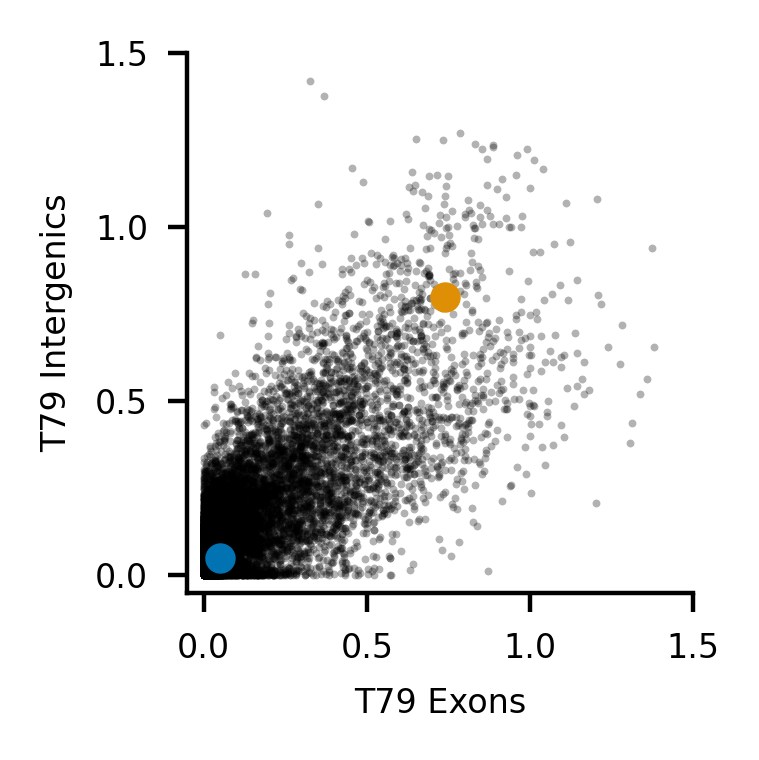

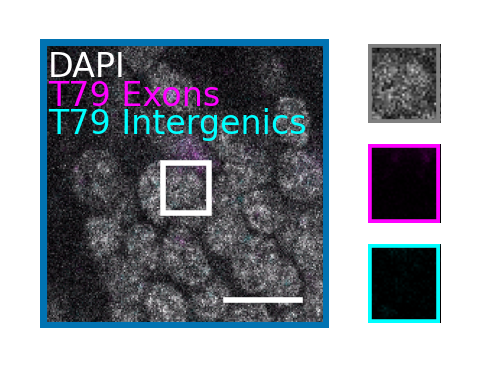

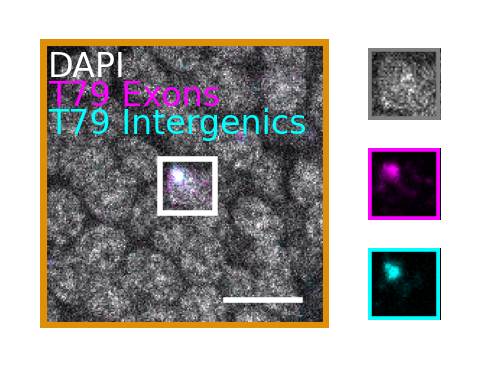

In [415]:
# T79-intergenic-b2-647 T79-exonic-b1-546 
plot_2_channels(results=results, image=image_data, metadata=metadata, 
                all_rois=all_rois, cell_borders=None, input=input, file=image, 
                c1="AF546-nuc-norm", c2="AF647-nuc-norm", 
                c1_name="T79 Exons", c2_name="T79 Intergenics",
                c1_color="magenta", c2_color="cyan",
                coordinates=[[0.05, 0.05], [0.8, 0.8]],
                dapi_max=100, c1_max=150, c2_max=200)

## Chymotrypsin (LOC105276652)

In [416]:
input = 'U34'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')
# Load the results 
results_dir = f'../results/{input}'
results_path = os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv')
results = pd.read_csv(results_path)

Using 20250307 B1 P14 U34-B3-546 Chymotrypsin-B2-647 DAPI as input directory


In [417]:
figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)
# Clear directory of files and subdirectories 
for f in os.listdir(figure_dir):
    if os.path.isfile(os.path.join(figure_dir, f)):
        os.remove(os.path.join(figure_dir, f))
    elif os.path.isdir(os.path.join(figure_dir, f)):
        for subf in os.listdir(os.path.join(figure_dir, f)):
            os.remove(os.path.join(figure_dir, f, subf))
        os.rmdir(os.path.join(figure_dir, f))

In [418]:
channels = ['AF546', 'AF647']
channel_names = ["U34", "LOC105276652"]
channel_colors = ["magenta", "cyan"]
channel_maxs = [255, 255]

In [419]:
# Normalize the nucleus mean signal for each channel and each image 
for channel in channels: 
    for image in results['image'].unique(): 
        nucleus_mean_signal = results.loc[results['image'] == image][f'{channel}-nucleus-mean'].values
        lower = np.quantile(nucleus_mean_signal, quantile)
        upper = np.quantile(nucleus_mean_signal, 1 - quantile)
        normalized = (nucleus_mean_signal - lower) / (upper - lower)
        results.loc[results['image'] == image, f'{channel}-nuc-norm'] = normalized

In [420]:
# Get the relative cytoplasmic intensity 
for channel in channels: 
    results[f'{channel}-cyto-prop'] = results[f'{channel}-cyto-mean'] / (results[f'{channel}-nucleus-mean'])

In [421]:
# Get only the cytoplasmic results
results_valence = results[results['cytoplasmic'].notnull()]

# Melt results_thresholded, grouping by image and cytoplasmic, for cytoplasm
results_melted_cyto = results_valence.melt(id_vars=['image', 'z', 'z_id', 'cytoplasmic', 'border_pxls'],
                                               value_vars=[c+"-cyto-prop" for c in channels],
                                               var_name='channel', 
                                               value_name='cyto-prop')
results_melted_cyto['channel'] = results_melted_cyto['channel'].str.replace('-cyto-prop', '')

# Melt results_thresholded, grouping by image and cytoplasmic, for nucleus
results_melted_nucleus = results_valence.melt(id_vars=['image', 'z', 'z_id', 'cytoplasmic', 'border_pxls'],
                                               value_vars=[c+"-nuc-norm" for c in channels],
                                               var_name='channel', 
                                               value_name='nuc-norm')
results_melted_nucleus['channel'] = results_melted_nucleus['channel'].str.replace('-nuc-norm', '')

# Combine the two melted dataframes
results_melted = pd.merge(results_melted_cyto, results_melted_nucleus, on=['image', 'z', 'z_id', 'cytoplasmic', 'channel', 'border_pxls'])
results_melted['channel_name'] = results_melted['channel'].map(dict(zip(channels, channel_names)))
results_melted['valence_OR_name'] = results_melted['cytoplasmic'].map(dict(zip(channels, channel_names)))
results_melted['valence_OR_name'] = results_melted['valence_OR_name'] + " valence OR"

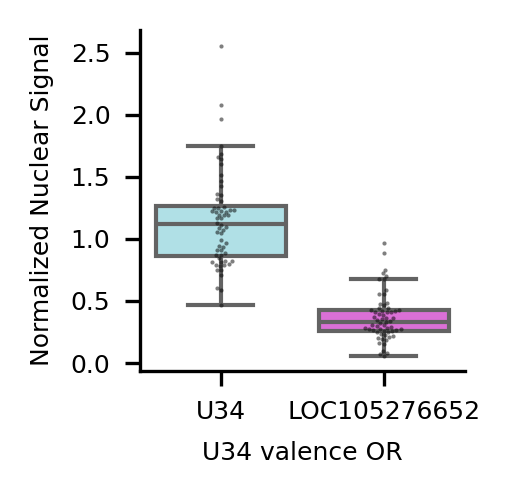

In [422]:
valence_channel = "U34 valence OR"
channels_to_plot = ["U34", "LOC105276652"]
plot_colors = ['powderblue', 'orchid', 'gold']
f, ax = plt.subplots(1, 1, figsize=(1.75, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Normalized Nuclear Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-norm-nuc.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

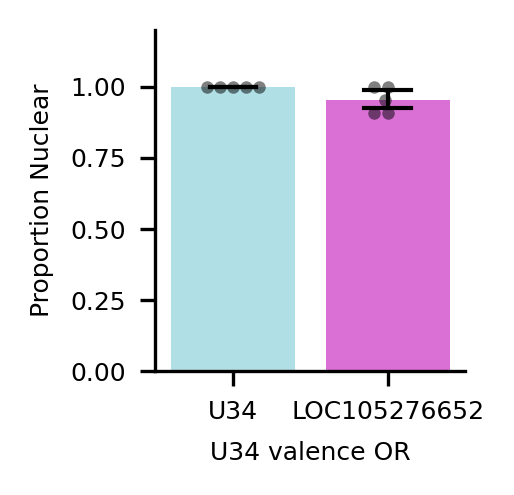

In [423]:
valence_channel = "U34 valence OR"
channels_to_plot = ["U34", "LOC105276652"]
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['nuc-norm'] > nuc_norm_threshold)).sum()).reset_index(name='nuclear')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['nuc-norm'].count().values
results_thresholded['prop-nuclear'] = results_thresholded['nuclear'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.75, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, palette=['powderblue', 'orchid', 'gold'], order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Nuclear", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-nuclear-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

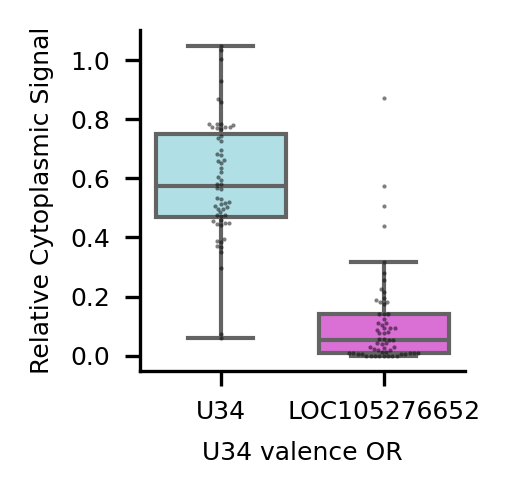

In [424]:
valence_channel = "U34 valence OR"
channels_to_plot = ["U34", "LOC105276652"]
f, ax = plt.subplots(1, 1, figsize=(1.75, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="cyto-prop", ax=ax, palette=['powderblue', 'orchid', 'gold'], order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="cyto-prop", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Relative Cytoplasmic Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-rel-cyto.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

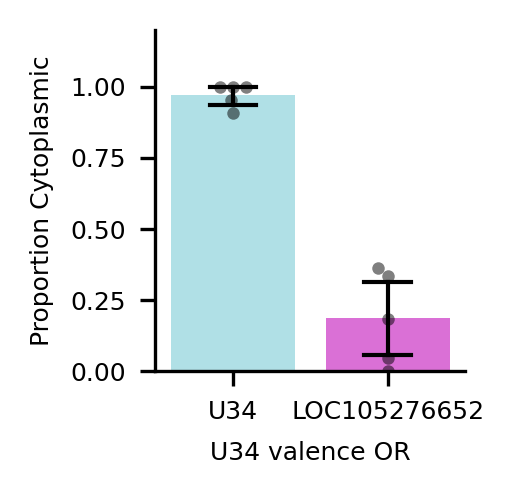

In [425]:
valence_channel = "U34 valence OR"
channels_to_plot = ["U34", "LOC105276652"]
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['cyto-prop'] > cyto_prop_threshold) & (x['nuc-norm'] > nuc_norm_threshold)).sum()).reset_index(name='cytoplasmic')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['cyto-prop'].count().values
results_thresholded['prop-cytoplasmic'] = results_thresholded['cytoplasmic'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.75, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, palette=['powderblue', 'orchid', 'gold'], order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Cytoplasmic", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-cyto-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

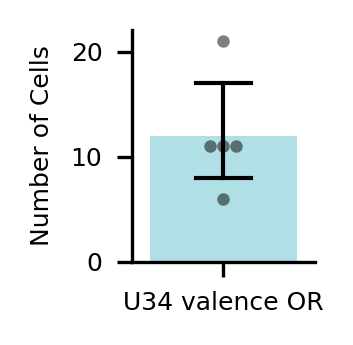

In [426]:
# Plot the number of cells 
valence_channel = "U34 valence OR"
valence_counts = results_melted.groupby(['image', 'valence_OR_name']).size().reset_index(name='num_cells')
valence_counts['num_cells'] = valence_counts['num_cells'] / len(results_melted['channel'].unique())
valence_counts['valence_OR_name'] = valence_counts['valence_OR_name'].str.replace('cytoplasmic', '\ncytoplasmic')
f, ax = plt.subplots(1, 1, figsize=(1.25, 1.25), dpi = 300) 
valence_counts_subset = valence_counts[valence_counts["valence_OR_name"] == valence_channel]
sns.barplot(data=valence_counts_subset, x="valence_OR_name", y="num_cells", ax=ax, palette=['powderblue'], saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=valence_counts_subset, x="valence_OR_name", y="num_cells", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"", fontsize=6)
ax.set_ylabel("Number of Cells", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-cell-counts.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

In [ ]:
file_number = 0 
results_files = os.listdir(f'../../../RNA-FISH-raw-data/{input}')
image = results_files[file_number].replace(".csv", ".czi")
image_path = f'../../../RNA-FISH-raw-data/{input}/{image}'
reader = napari_get_reader(image_path)
if reader is not None:
    layer_data = reader(image_path)
    image_data, metadata, layer_type = layer_data[0]
    print(f"Loaded {image_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

# Load ROIs 
all_rois_path = f'../results/{input}/{image.replace(".czi", "_rois.npy")}'
all_rois = np.load(all_rois_path)
print(f"Loaded {all_rois_path}")

# Load cell_borders 
cell_borders_path = f'../results/{input}/{image.replace(".czi", "_cell_borders.npy")}'
cell_borders = np.load(cell_borders_path)
print(f"Loaded {cell_borders_path}")

Loaded ../raw-data/20250307 B1 P14 U34-B3-546 Chymotrypsin-B2-647 DAPI/20250307 B1 Sample 5 Stack.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 0.0, 0.0), 'scale': (1.0, 0.5, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF546-T1', 'DAPI-T2', 'AF647-T2']}
Image shape: (1, 202, 3, 2048, 2048)
Loaded ../results/20250307 B1 P14 U34-B3-546 Chymotrypsin-B2-647 DAPI/20250307 B1 Sample 5 Stack_rois.npy
Loaded ../results/20250307 B1 P14 U34-B3-546 Chymotrypsin-B2-647 DAPI/20250307 B1 Sample 5 Stack_cell_borders.npy


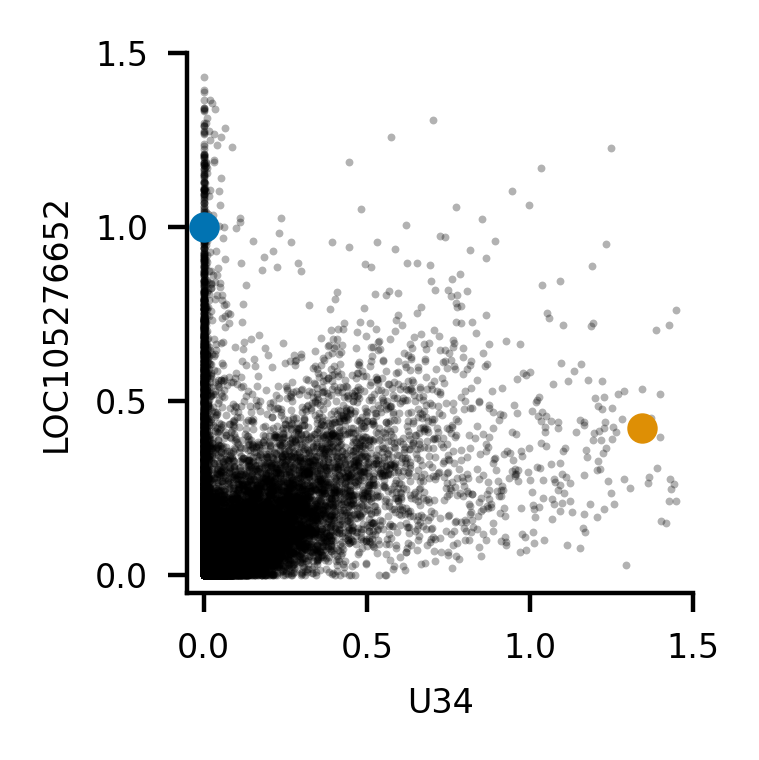

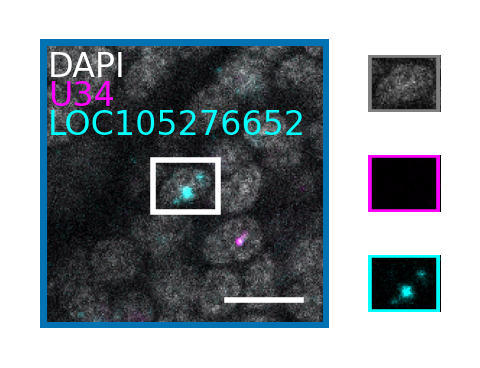

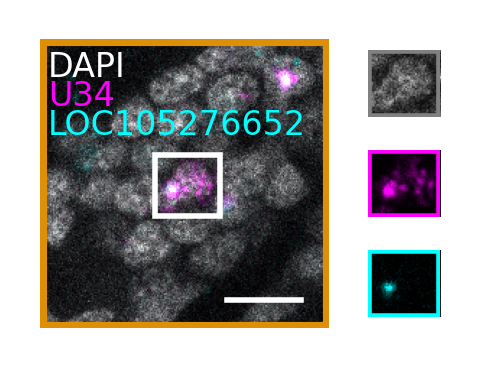

In [428]:
# U34-B3-546 Chymotrypsin-B2-647
plot_2_channels(results=results, image=image_data, metadata=metadata, 
                all_rois=all_rois, cell_borders=cell_borders, input=input, file=image, 
                c1="AF546-nuc-norm", c2="AF647-nuc-norm", 
                c1_name="U34", c2_name="LOC105276652",
                c1_color="magenta", c2_color="cyan",
                coordinates=[[0, 1], [1.4, 0.5]],
                dapi_max=200, c1_max=200, c2_max=200)

## U34, U21, PR

In [5]:
input = 'u21'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')
# Load the results 
results_dir = f'../results/{input}'
results_path = os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv')
results = pd.read_csv(results_path)

Using 20250325 4 p14 u34-b3-488 lnc4-b1-546 u21-b5-647 dapi as input directory


In [6]:
figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)
# Clear directory of files and subdirectories 
for f in os.listdir(figure_dir):
    if os.path.isfile(os.path.join(figure_dir, f)):
        os.remove(os.path.join(figure_dir, f))
    elif os.path.isdir(os.path.join(figure_dir, f)):
        for subf in os.listdir(os.path.join(figure_dir, f)):
            os.remove(os.path.join(figure_dir, f, subf))
        os.rmdir(os.path.join(figure_dir, f))

In [7]:
channels = ['AF488', 'AF546', 'AF647']
channel_names = ["U34", "PR", "U21"]
channel_colors = ["yellow", "magenta", "cyan"]
channel_maxs = [255, 255, 255]

In [8]:
# Normalize the nucleus mean signal for each channel and each image 
for channel in channels: 
    for image in results['image'].unique(): 
        nucleus_mean_signal = results.loc[results['image'] == image][f'{channel}-nucleus-mean'].values
        lower = np.quantile(nucleus_mean_signal, quantile)
        upper = np.quantile(nucleus_mean_signal, 1 - quantile)
        normalized = (nucleus_mean_signal - lower) / (upper - lower)
        results.loc[results['image'] == image, f'{channel}-nuc-norm'] = normalized

In [9]:
# Get the relative cytoplasmic intensity 
for channel in channels: 
    results[f'{channel}-cyto-prop'] = results[f'{channel}-cyto-mean'] / (results[f'{channel}-nucleus-mean'])

In [10]:
# Get only the cytoplasmic results
results_valence = results[results['cytoplasmic'].notnull()]

# Melt results_thresholded, grouping by image and cytoplasmic, for cytoplasm
results_melted_cyto = results_valence.melt(id_vars=['image', 'z', 'z_id', 'cytoplasmic', 'border_pxls'],
                                               value_vars=[c+"-cyto-prop" for c in channels],
                                               var_name='channel', 
                                               value_name='cyto-prop')
results_melted_cyto['channel'] = results_melted_cyto['channel'].str.replace('-cyto-prop', '')

# Melt results_thresholded, grouping by image and cytoplasmic, for nucleus
results_melted_nucleus = results_valence.melt(id_vars=['image', 'z', 'z_id', 'cytoplasmic', 'border_pxls'],
                                               value_vars=[c+"-nuc-norm" for c in channels],
                                               var_name='channel', 
                                               value_name='nuc-norm')
results_melted_nucleus['channel'] = results_melted_nucleus['channel'].str.replace('-nuc-norm', '')

# Combine the two melted dataframes
results_melted = pd.merge(results_melted_cyto, results_melted_nucleus, on=['image', 'z', 'z_id', 'cytoplasmic', 'channel', 'border_pxls'])
results_melted['channel_name'] = results_melted['channel'].map(dict(zip(channels, channel_names)))
results_melted['valence_OR_name'] = results_melted['cytoplasmic'].map(dict(zip(channels, channel_names)))
results_melted['valence_OR_name'] = results_melted['valence_OR_name'] + " valence OR"

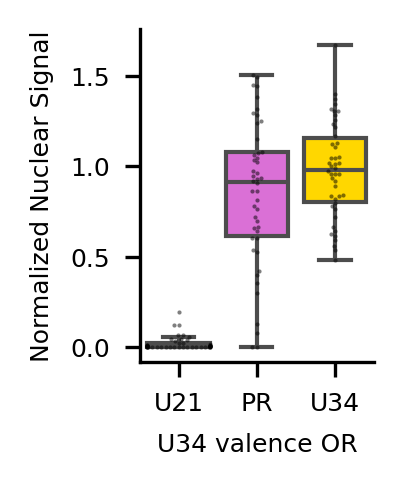

In [11]:
valence_channel = "U34 valence OR"
channels_to_plot = ["U21", "PR", "U34"]
plot_colors =['powderblue', 'orchid', 'gold']
f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Normalized Nuclear Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-norm-nuc.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

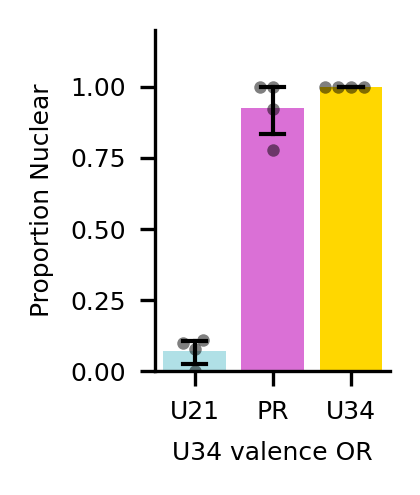

In [12]:
valence_channel = "U34 valence OR"
channels_to_plot = ["U21", "PR", "U34"]
plot_colors =['powderblue', 'orchid', 'gold']
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['nuc-norm'] > nuc_norm_threshold)).sum()).reset_index(name='nuclear')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['nuc-norm'].count().values
results_thresholded['prop-nuclear'] = results_thresholded['nuclear'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Nuclear", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-nuclear-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

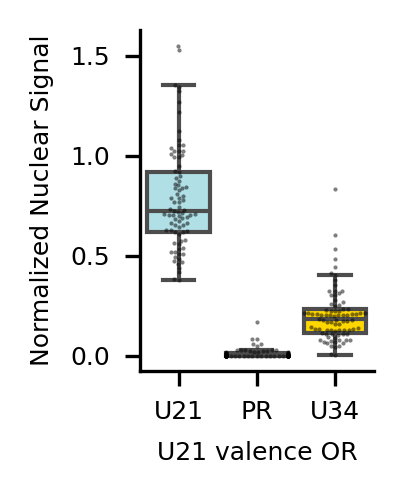

In [13]:
valence_channel = "U21 valence OR"
channels_to_plot = ["U21", "PR", "U34"]
plot_colors =['powderblue', 'orchid', 'gold']
f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Normalized Nuclear Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-norm-nuc.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

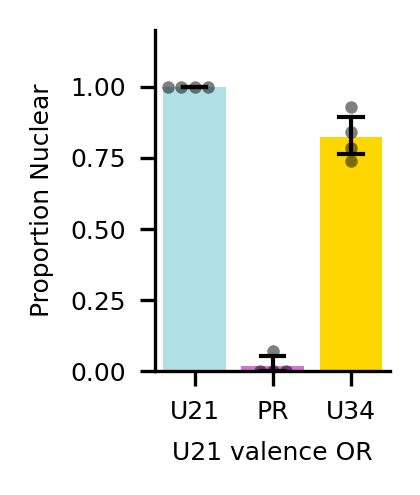

In [14]:
valence_channel = "U21 valence OR"
channels_to_plot = ["U21", "PR", "U34"]
plot_colors = ['powderblue', 'orchid', 'gold']
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['nuc-norm'] > nuc_norm_threshold)).sum()).reset_index(name='nuclear')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['nuc-norm'].count().values
results_thresholded['prop-nuclear'] = results_thresholded['nuclear'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Nuclear", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-nuclear-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

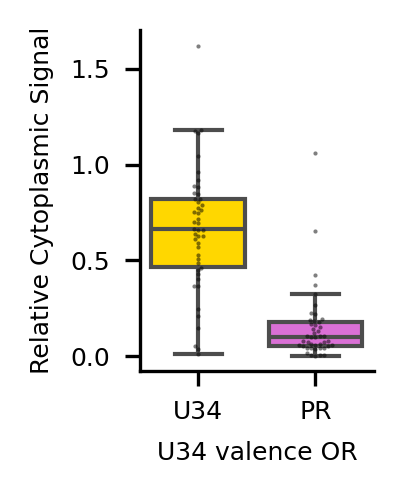

In [15]:
valence_channel = "U34 valence OR"
channels_to_plot = ["U34", "PR"]
plot_colors = ['gold', 'orchid']
f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="cyto-prop", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="cyto-prop", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Relative Cytoplasmic Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-rel-cyto.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

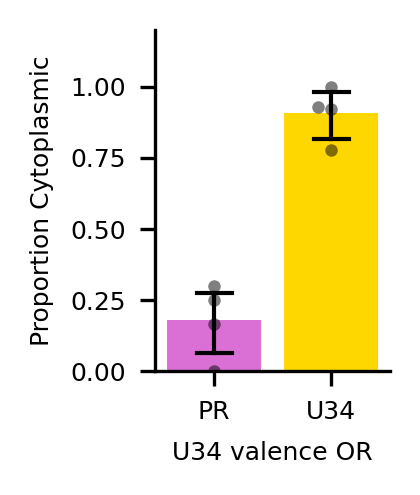

In [16]:
valence_channel = "U34 valence OR"
channels_to_plot = ["PR", "U34"]
plot_colors = ['orchid', 'gold']
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['cyto-prop'] > cyto_prop_threshold) & (x['nuc-norm'] > nuc_norm_threshold)).sum()).reset_index(name='cytoplasmic')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['cyto-prop'].count().values
results_thresholded['prop-cytoplasmic'] = results_thresholded['cytoplasmic'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Cytoplasmic", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-cyto-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

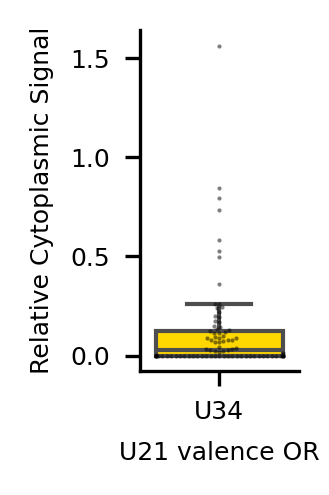

In [17]:
valence_channel = "U21 valence OR"
channels_to_plot = ["U34"]
f, ax = plt.subplots(1, 1, figsize=(1.25, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="cyto-prop", ax=ax, palette=['gold', 'orchid', 'gold'], order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="cyto-prop", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Relative Cytoplasmic Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-rel-cyto.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

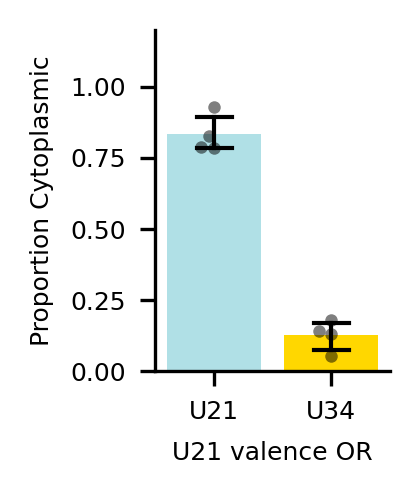

In [18]:
valence_channel = "U21 valence OR"
channels_to_plot = ["U21", "U34"]
plot_colors = ['powderblue', 'gold']
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['cyto-prop'] > cyto_prop_threshold) & (x['nuc-norm'] > nuc_norm_threshold)).sum()).reset_index(name='cytoplasmic')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['cyto-prop'].count().values
results_thresholded['prop-cytoplasmic'] = results_thresholded['cytoplasmic'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Cytoplasmic", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

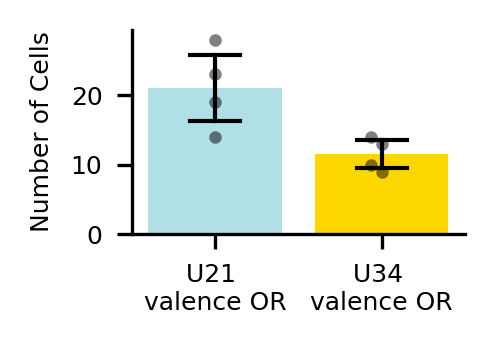

In [19]:
# Plot the number of cells 
valence_counts = results_melted.groupby(['image', 'valence_OR_name']).size().reset_index(name='num_cells')
valence_counts['num_cells'] = valence_counts['num_cells'] / len(results_melted['channel'].unique())
valence_counts['valence_OR_name'] = valence_counts['valence_OR_name'].str.replace('valence OR', '\nvalence OR')
f, ax = plt.subplots(1, 1, figsize=(1.75, 1.25), dpi = 300) 
sns.barplot(data=valence_counts, x="valence_OR_name", y="num_cells", ax=ax, palette=['powderblue', 'gold'], saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=valence_counts, x="valence_OR_name", y="num_cells", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"", fontsize=6)
ax.set_ylabel("Number of Cells", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-cell-counts.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

In [ ]:
file_number = 0 
results_files = os.listdir(f'../../../RNA-FISH-raw-data/{input}')
image = results_files[file_number].replace(".csv", ".czi")
image_path = f'../../../RNA-FISH-raw-data/{input}/{image}'
reader = napari_get_reader(image_path)
if reader is not None:
    layer_data = reader(image_path)
    image_data, metadata, layer_type = layer_data[0]
    print(f"Loaded {image_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

# Load ROIs 
all_rois_path = f'../results/{input}/{image.replace(".czi", "_rois.npy")}'
all_rois = np.load(all_rois_path)
print(f"Loaded {all_rois_path}")

# Load cell_borders 
cell_borders_path = f'../results/{input}/{image.replace(".czi", "_cell_borders.npy")}'
cell_borders = np.load(cell_borders_path)
print(f"Loaded {cell_borders_path}")

Loaded ../raw-data/20250325 4 p14 u34-b3-488 lnc4-b1-546 u21-b5-647 dapi/20250325 4 t19 lncrna sample 4 great.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 30779.721115112305, 26878.52767944336), 'scale': (1.0, 1.0, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF546-T1', 'AF488-T2', 'DAPI-T3', 'AF647-T3']}
Image shape: (1, 80, 4, 2048, 2048)
Loaded ../results/20250325 4 p14 u34-b3-488 lnc4-b1-546 u21-b5-647 dapi/20250325 4 t19 lncrna sample 4 great_rois.npy
Loaded ../results/20250325 4 p14 u34-b3-488 lnc4-b1-546 u21-b5-647 dapi/20250325 4 t19 lncrna sample 4 great_cell_borders.npy


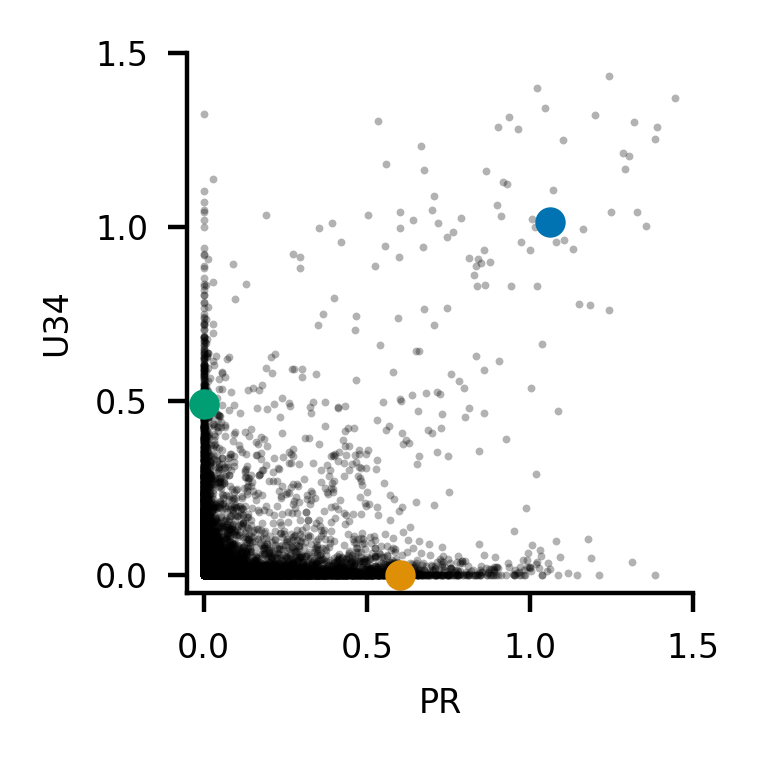

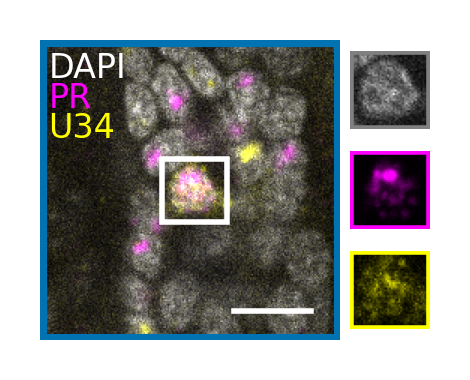

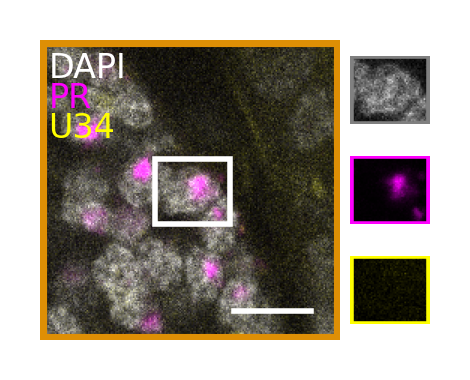

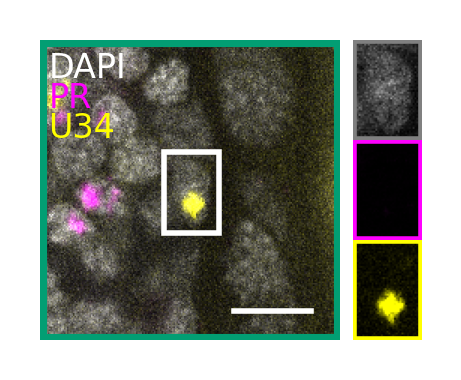

In [445]:
# u34-b3-488 lnc4-b1-546 u21-b5-647
plot_2_channels(results=results, image=image_data, metadata=metadata, 
                all_rois=all_rois, cell_borders=cell_borders, input=input, file=image, 
                c1="AF546-nuc-norm", c2="AF488-nuc-norm", 
                c1_name="PR", c2_name="U34",
                c1_color="magenta", c2_color="yellow",
                coordinates=[[1.1, 1.1], [0.6, 0], [0, 0.5]],
                dapi_max=200, c1_max=200, c2_max=150)

## L16 & PR

In [446]:
input = 'L16'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')
# Load the results 
results_dir = f'../results/{input}'
results_path = os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv')
results = pd.read_csv(results_path)

Using 20250328 3 P14 Lnc3-b3-488 L16-b2-594 Lnc2-b5-647 DAPI as input directory


In [447]:
figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)
# Clear directory of files and subdirectories 
for f in os.listdir(figure_dir):
    if os.path.isfile(os.path.join(figure_dir, f)):
        os.remove(os.path.join(figure_dir, f))
    elif os.path.isdir(os.path.join(figure_dir, f)):
        for subf in os.listdir(os.path.join(figure_dir, f)):
            os.remove(os.path.join(figure_dir, f, subf))
        os.rmdir(os.path.join(figure_dir, f))

In [448]:
channels = ['AF594', 'AF647']
channel_names = ["L16", "PR"]
channel_colors = ["cyan", "yellow"]
channel_maxs = [255, 255]

In [449]:
# Normalize the nucleus mean signal for each channel and each image 
for channel in channels: 
    for image in results['image'].unique(): 
        nucleus_mean_signal = results.loc[results['image'] == image][f'{channel}-nucleus-mean'].values
        lower = np.quantile(nucleus_mean_signal, quantile)
        upper = np.quantile(nucleus_mean_signal, 1 - quantile)
        normalized = (nucleus_mean_signal - lower) / (upper - lower)
        results.loc[results['image'] == image, f'{channel}-nuc-norm'] = normalized

In [450]:
# Get the relative cytoplasmic intensity 
for channel in channels: 
    results[f'{channel}-cyto-prop'] = results[f'{channel}-cyto-mean'] / (results[f'{channel}-nucleus-mean'])

In [451]:
# Get only the cytoplasmic results
results_valence = results[results['cytoplasmic'].notnull()]

# Melt results_thresholded, grouping by image and cytoplasmic, for cytoplasm
results_melted_cyto = results_valence.melt(id_vars=['image', 'z', 'z_id', 'cytoplasmic', 'border_pxls'],
                                               value_vars=[c+"-cyto-prop" for c in channels],
                                               var_name='channel', 
                                               value_name='cyto-prop')
results_melted_cyto['channel'] = results_melted_cyto['channel'].str.replace('-cyto-prop', '')

# Melt results_thresholded, grouping by image and cytoplasmic, for nucleus
results_melted_nucleus = results_valence.melt(id_vars=['image', 'z', 'z_id', 'cytoplasmic', 'border_pxls'],
                                               value_vars=[c+"-nuc-norm" for c in channels],
                                               var_name='channel', 
                                               value_name='nuc-norm')
results_melted_nucleus['channel'] = results_melted_nucleus['channel'].str.replace('-nuc-norm', '')

# Combine the two melted dataframes
results_melted = pd.merge(results_melted_cyto, results_melted_nucleus, on=['image', 'z', 'z_id', 'cytoplasmic', 'channel', 'border_pxls'])
results_melted['channel_name'] = results_melted['channel'].map(dict(zip(channels, channel_names)))
results_melted['valence_OR_name'] = results_melted['cytoplasmic'].map(dict(zip(channels, channel_names)))
results_melted['valence_OR_name'] = results_melted['valence_OR_name'] + " valence OR"

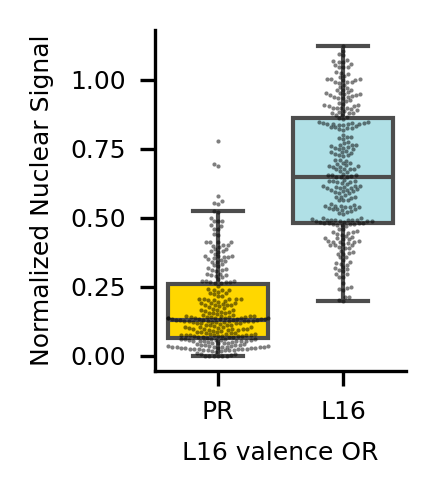

In [452]:
valence_channel = "L16 valence OR"
channels_to_plot = ["PR", "L16"]
f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, palette=['gold', 'powderblue'], order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Normalized Nuclear Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-mean-norm-nuc.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

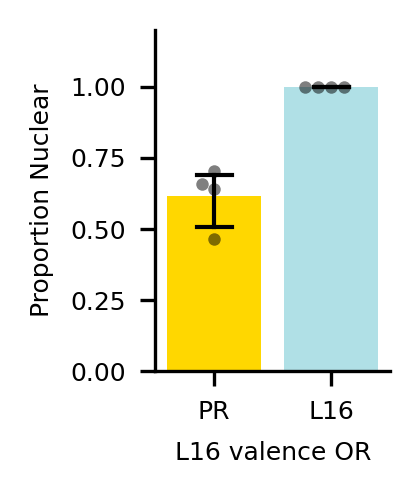

In [453]:
valence_channel = "L16 valence OR"
channels_to_plot = ["PR", "L16"]
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['nuc-norm'] > nuc_norm_threshold)).sum()).reset_index(name='nuclear')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['nuc-norm'].count().values
results_thresholded['prop-nuclear'] = results_thresholded['nuclear'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, palette=['gold', 'powderblue'], order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Nuclear", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-nuclear-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

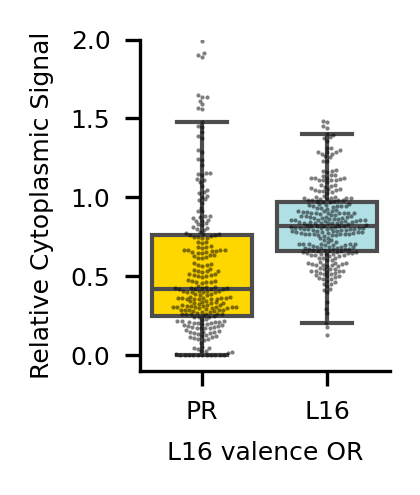

In [454]:
valence_channel = "L16 valence OR"
channels_to_plot = ["PR", "L16"]
f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="cyto-prop", ax=ax, palette=['gold', 'powderblue'], order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="cyto-prop", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Relative Cytoplasmic Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(-0.1, 2)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-rel-cyto.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

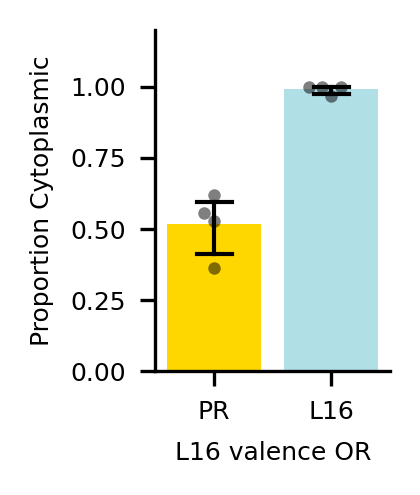

In [455]:
valence_channel = "L16 valence OR"
channels_to_plot = ["PR", "L16"]
plot_colors = ['gold', 'powderblue']
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['cyto-prop'] > cyto_prop_threshold) & (x['nuc-norm'] > nuc_norm_threshold)).sum()).reset_index(name='cytoplasmic')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['cyto-prop'].count().values
results_thresholded['prop-cytoplasmic'] = results_thresholded['cytoplasmic'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Cytoplasmic", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-cyto-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

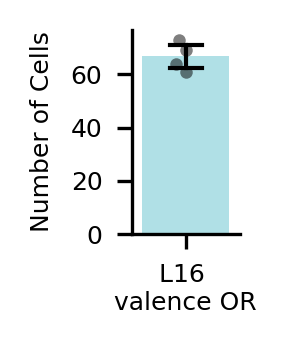

In [456]:
# Plot the number of cells 
valence_channel = "L16 \nvalence OR"
valence_counts = results_melted.groupby(['image', 'valence_OR_name']).size().reset_index(name='num_cells')
valence_counts['num_cells'] = valence_counts['num_cells'] / len(results_melted['channel'].unique())
valence_counts['valence_OR_name'] = valence_counts['valence_OR_name'].str.replace('valence OR', '\nvalence OR')
f, ax = plt.subplots(1, 1, figsize=(1, 1.25), dpi = 300) 
valence_counts_subset = valence_counts[valence_counts["valence_OR_name"] == valence_channel]
sns.barplot(data=valence_counts_subset, x="valence_OR_name", y="num_cells", ax=ax, palette=['powderblue'], saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=valence_counts_subset, x="valence_OR_name", y="num_cells", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"", fontsize=6)
ax.set_ylabel("Number of Cells", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-cell-counts.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

In [ ]:
file_number = 2
results_files = os.listdir(f'../../../RNA-FISH-raw-data/{input}')
image = results_files[file_number].replace(".csv", ".czi")
image_path = f'../../../RNA-FISH-raw-data/{input}/{image}'
reader = napari_get_reader(image_path)
if reader is not None:
    layer_data = reader(image_path)
    image_data, metadata, layer_type = layer_data[0]
    print(f"Loaded {image_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

# Load ROIs 
all_rois_path = f'../results/{input}/{image.replace(".czi", "_rois.npy")}'
all_rois = np.load(all_rois_path)
print(f"Loaded {all_rois_path}")

# Load cell_borders 
cell_borders_path = f'../results/{input}/{image.replace(".czi", "_cell_borders.npy")}'
cell_borders = np.load(cell_borders_path)
print(f"Loaded {cell_borders_path}")

Loaded ../raw-data/20250328 3 P14 Lnc3-b3-488 L16-b2-594 Lnc2-b5-647 DAPI/20250328 3 L16lnc sample 3.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 0.0, 0.0), 'scale': (1.0, 1.0, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF488-T1', 'AF647-T1', 'DAPI-T2', 'AF594-T2']}
Image shape: (1, 81, 4, 2048, 2048)
Loaded ../results/20250328 3 P14 Lnc3-b3-488 L16-b2-594 Lnc2-b5-647 DAPI/20250328 3 L16lnc sample 3_rois.npy
Loaded ../results/20250328 3 P14 Lnc3-b3-488 L16-b2-594 Lnc2-b5-647 DAPI/20250328 3 L16lnc sample 3_cell_borders.npy


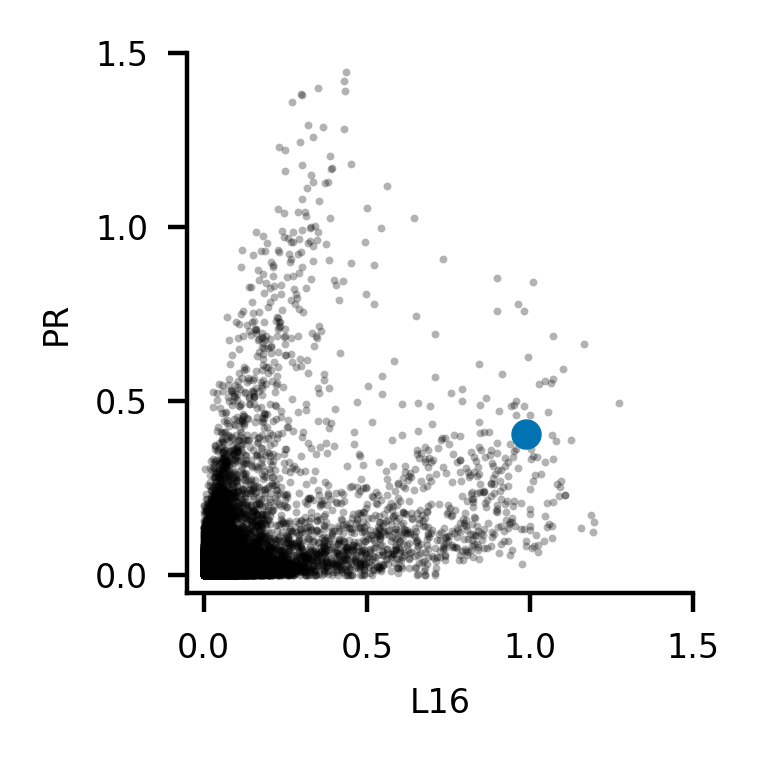

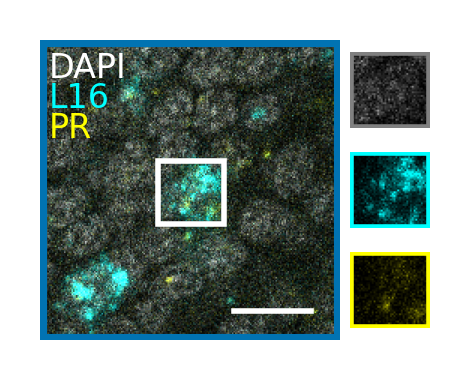

In [458]:
# Lnc3-b3-488 L16-b2-594 Lnc2-b5-647
plot_2_channels(results=results, image=image_data, metadata=metadata, 
                all_rois=all_rois, cell_borders=cell_borders, input=input, file=image, 
                c1="AF594-nuc-norm", c2="AF647-nuc-norm", 
                c1_name="L16", c2_name="PR",
                c1_color="cyan", c2_color="yellow",
                coordinates=[[1, 0.4]], bbox_expansion=7,
                dapi_max=100, c1_max=150, c2_max=100)

## G1

In [553]:
input = 'g1'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')
# Load the results 
results_dir = f'../results/{input}'
results_path = os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv')
results = pd.read_csv(results_path)

Using 20250325 5 p14 g1-b1-546 lnc7-b2-647 dapi as input directory


In [554]:
figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)
# Clear directory of files and subdirectories 
for f in os.listdir(figure_dir):
    if os.path.isfile(os.path.join(figure_dir, f)):
        os.remove(os.path.join(figure_dir, f))
    elif os.path.isdir(os.path.join(figure_dir, f)):
        for subf in os.listdir(os.path.join(figure_dir, f)):
            os.remove(os.path.join(figure_dir, f, subf))
        os.rmdir(os.path.join(figure_dir, f))

In [555]:
channels = ['AF546', 'AF647']
channel_names = ["G1", "LOC113562161"]
channel_colors = ["magenta", "cyan"]
channel_maxs = [255, 255]

In [556]:
# Normalize the nucleus mean signal for each channel and each image 
for channel in channels: 
    for image in results['image'].unique(): 
        nucleus_mean_signal = results.loc[results['image'] == image][f'{channel}-nucleus-mean'].values
        lower = np.quantile(nucleus_mean_signal, quantile)
        upper = np.quantile(nucleus_mean_signal, 1 - quantile)
        normalized = (nucleus_mean_signal - lower) / (upper - lower)
        results.loc[results['image'] == image, f'{channel}-nuc-norm'] = normalized

In [557]:
# Pearson correlation of AF546-nuc-norm and AF647-nuc-norm
from scipy.stats import pearsonr
r, p = pearsonr(results['AF546-nuc-norm'], results['AF647-nuc-norm'])
print(f"Pearson correlation coefficient: {r}, p-value: {p}")

Pearson correlation coefficient: 0.8778416120708775, p-value: 0.0


In [558]:
# Get the relative cytoplasmic intensity 
for channel in channels: 
    results[f'{channel}-cyto-prop'] = results[f'{channel}-cyto-mean'] / (results[f'{channel}-nucleus-mean'])

In [559]:
# Get only the cytoplasmic results
results_valence = results[results['cytoplasmic'].notnull()]

# Melt results_thresholded, grouping by image and cytoplasmic, for cytoplasm
results_melted_cyto = results_valence.melt(id_vars=['image', 'z', 'z_id', 'cytoplasmic', 'border_pxls'],
                                               value_vars=[c+"-cyto-prop" for c in channels],
                                               var_name='channel', 
                                               value_name='cyto-prop')
results_melted_cyto['channel'] = results_melted_cyto['channel'].str.replace('-cyto-prop', '')

# Melt results_thresholded, grouping by image and cytoplasmic, for nucleus
results_melted_nucleus = results_valence.melt(id_vars=['image', 'z', 'z_id', 'cytoplasmic', 'border_pxls'],
                                               value_vars=[c+"-nuc-norm" for c in channels],
                                               var_name='channel', 
                                               value_name='nuc-norm')
results_melted_nucleus['channel'] = results_melted_nucleus['channel'].str.replace('-nuc-norm', '')

# Combine the two melted dataframes
results_melted = pd.merge(results_melted_cyto, results_melted_nucleus, on=['image', 'z', 'z_id', 'cytoplasmic', 'channel', 'border_pxls'])
results_melted['channel_name'] = results_melted['channel'].map(dict(zip(channels, channel_names)))
results_melted['valence_OR_name'] = results_melted['cytoplasmic'].map(dict(zip(channels, channel_names)))
results_melted['valence_OR_name'] = results_melted['valence_OR_name'] + " valence OR"

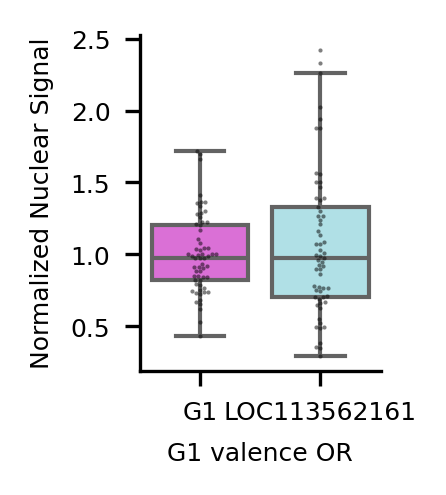

In [560]:
valence_channel = "G1 valence OR"
channels_to_plot = ["G1", "LOC113562161"]
f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, palette=['orchid', 'powderblue'], order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Normalized Nuclear Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-mean-norm-nuc.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

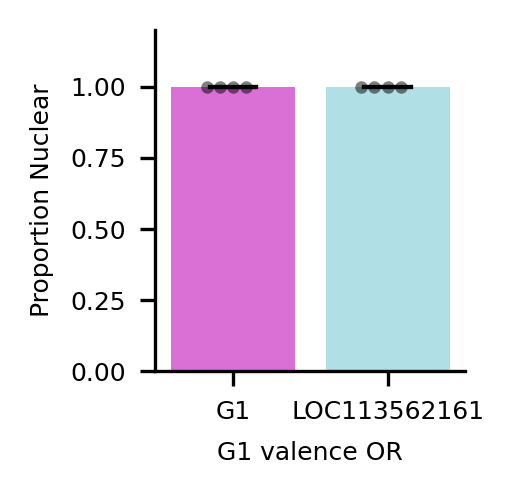

In [562]:
valence_channel = "G1 valence OR"
channels_to_plot = ["G1", "LOC113562161"]
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['nuc-norm'] > nuc_norm_threshold)).sum()).reset_index(name='nuclear')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['nuc-norm'].count().values
results_thresholded['prop-nuclear'] = results_thresholded['nuclear'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.75, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, palette=['orchid', 'powderblue'], order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Nuclear", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-nuclear-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

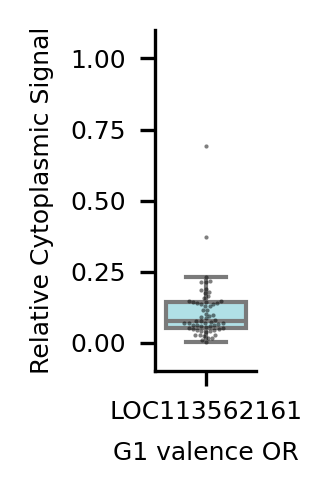

In [563]:
valence_channel = "G1 valence OR"
channels_to_plot = ["LOC113562161"]
f, ax = plt.subplots(1, 1, figsize=(1, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="cyto-prop", ax=ax, palette=['powderblue'], order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="cyto-prop", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Relative Cytoplasmic Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(-0.1, 1.1)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-rel-cyto.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

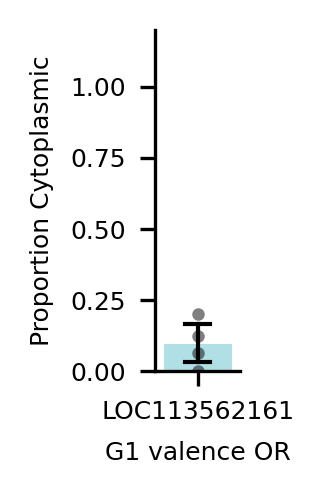

In [564]:
valence_channel = "G1 valence OR"
channels_to_plot = ["LOC113562161"]
plot_colors = ['powderblue']
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['cyto-prop'] > cyto_prop_threshold) & (x['nuc-norm'] > nuc_norm_threshold)).sum()).reset_index(name='cytoplasmic')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['cyto-prop'].count().values
results_thresholded['prop-cytoplasmic'] = results_thresholded['cytoplasmic'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Cytoplasmic", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-cyto-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

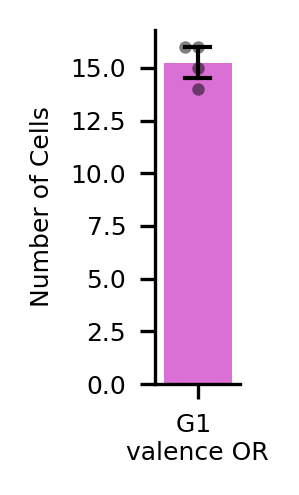

In [565]:
# Plot the number of cells 
valence_channel = "G1 \nvalence OR"
valence_counts = results_melted.groupby(['image', 'valence_OR_name']).size().reset_index(name='num_cells')
valence_counts['num_cells'] = valence_counts['num_cells'] / len(results_melted['channel'].unique())
valence_counts['valence_OR_name'] = valence_counts['valence_OR_name'].str.replace('valence OR', '\nvalence OR')
f, ax = plt.subplots(1, 1, figsize=(1, 1.75), dpi = 300) 
valence_counts_subset = valence_counts[valence_counts["valence_OR_name"] == valence_channel]
sns.barplot(data=valence_counts_subset, x="valence_OR_name", y="num_cells", ax=ax, palette=['orchid'], saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=valence_counts_subset, x="valence_OR_name", y="num_cells", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"", fontsize=6)
ax.set_ylabel("Number of Cells", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-cell-counts.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

In [ ]:
file_number = 0
results_files = os.listdir(f'../../../RNA-FISH-raw-data/{input}')
image = results_files[file_number].replace(".csv", ".czi")
image_path = f'../../../RNA-FISH-raw-data/{input}/{image}'
reader = napari_get_reader(image_path)
if reader is not None:
    layer_data = reader(image_path)
    image_data, metadata, layer_type = layer_data[0]
    print(f"Loaded {image_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

# Load ROIs 
all_rois_path = f'../results/{input}/{image.replace(".czi", "_rois.npy")}'
all_rois = np.load(all_rois_path)
print(f"Loaded {all_rois_path}")

# Load cell_borders 
cell_borders_path = f'../results/{input}/{image.replace(".czi", "_cell_borders.npy")}'
cell_borders = np.load(cell_borders_path)
print(f"Loaded {cell_borders_path}")

Loaded ../raw-data/20250325 5 p14 g1-b1-546 lnc7-b2-647 dapi/20250325 5 G1 lncrna sample 2 great.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 0.0, 0.0), 'scale': (1.0, 1.0, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF546-T1', 'DAPI-T2', 'AF647-T2']}
Image shape: (1, 78, 3, 2048, 2048)
Loaded ../results/20250325 5 p14 g1-b1-546 lnc7-b2-647 dapi/20250325 5 G1 lncrna sample 2 great_rois.npy
Loaded ../results/20250325 5 p14 g1-b1-546 lnc7-b2-647 dapi/20250325 5 G1 lncrna sample 2 great_cell_borders.npy


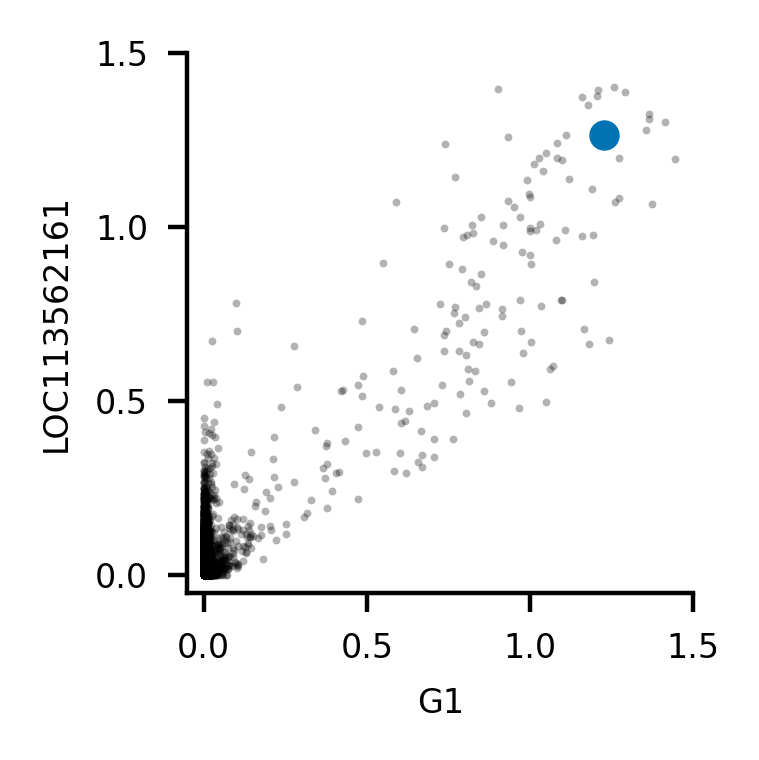

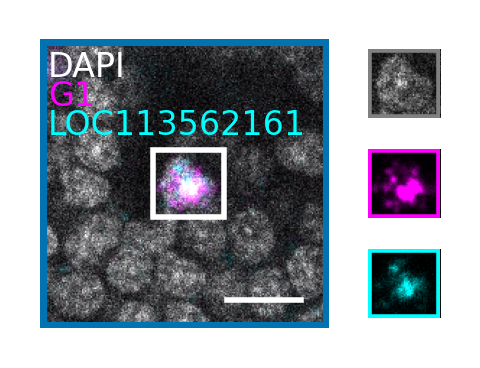

In [472]:
# g1-b1-546 lnc7-b2-647
plot_2_channels(results, image=image_data, metadata=metadata, 
                all_rois=all_rois, cell_borders=cell_borders, input=input, file=image, 
                c1="AF546-nuc-norm", c2="AF647-nuc-norm", 
                c1_name="G1", c2_name="LOC113562161",
                c1_color="magenta", c2_color="cyan",
                coordinates=[[1.25, 1.25]],
                dapi_max=100, c1_max=150, c2_max=150)

## Q1, R2, PR

In [473]:
input = 'Q1'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')
# Load the results 
results_dir = f'../results/{input}'
results_path = os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv')
results = pd.read_csv(results_path)

Using 20250328 2 P14 R2-b3-488 Q1-b1-546 Lnc6-b2-647 DAPI as input directory


In [474]:
figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)
# Clear directory of files and subdirectories 
for f in os.listdir(figure_dir):
    if os.path.isfile(os.path.join(figure_dir, f)):
        os.remove(os.path.join(figure_dir, f))
    elif os.path.isdir(os.path.join(figure_dir, f)):
        for subf in os.listdir(os.path.join(figure_dir, f)):
            os.remove(os.path.join(figure_dir, f, subf))
        os.rmdir(os.path.join(figure_dir, f))

In [475]:
channels = ['AF488', 'AF546', 'AF647']
channel_names = ["R2-3", "Q1", "PR"]
channel_colors = ["yellow", "magenta", "cyan"]
channel_maxs = [255, 255, 255]

In [476]:
# Normalize the nucleus mean signal for each channel and each image 
for channel in channels: 
    for image in results['image'].unique(): 
        nucleus_mean_signal = results.loc[results['image'] == image][f'{channel}-nucleus-mean'].values
        lower = np.quantile(nucleus_mean_signal, quantile)
        upper = np.quantile(nucleus_mean_signal, 1 - quantile)
        normalized = (nucleus_mean_signal - lower) / (upper - lower)
        results.loc[results['image'] == image, f'{channel}-nuc-norm'] = normalized

In [477]:
# Get the relative cytoplasmic intensity 
for channel in channels: 
    results[f'{channel}-cyto-prop'] = results[f'{channel}-cyto-mean'] / (results[f'{channel}-nucleus-mean'])

In [478]:
# Get only the cytoplasmic results
results_valence = results[results['cytoplasmic'].notnull()]

# Melt results_thresholded, grouping by image and cytoplasmic, for cytoplasm
results_melted_cyto = results_valence.melt(id_vars=['image', 'z', 'z_id', 'cytoplasmic', 'border_pxls'],
                                               value_vars=[c+"-cyto-prop" for c in channels],
                                               var_name='channel', 
                                               value_name='cyto-prop')
results_melted_cyto['channel'] = results_melted_cyto['channel'].str.replace('-cyto-prop', '')

# Melt results_thresholded, grouping by image and cytoplasmic, for nucleus
results_melted_nucleus = results_valence.melt(id_vars=['image', 'z', 'z_id', 'cytoplasmic', 'border_pxls'],
                                               value_vars=[c+"-nuc-norm" for c in channels],
                                               var_name='channel', 
                                               value_name='nuc-norm')
results_melted_nucleus['channel'] = results_melted_nucleus['channel'].str.replace('-nuc-norm', '')

# Combine the two melted dataframes
results_melted = pd.merge(results_melted_cyto, results_melted_nucleus, on=['image', 'z', 'z_id', 'cytoplasmic', 'channel', 'border_pxls'])
results_melted['channel_name'] = results_melted['channel'].map(dict(zip(channels, channel_names)))
results_melted['valence_OR_name'] = results_melted['cytoplasmic'].map(dict(zip(channels, channel_names)))
results_melted['valence_OR_name'] = results_melted['valence_OR_name'] + " valence OR"

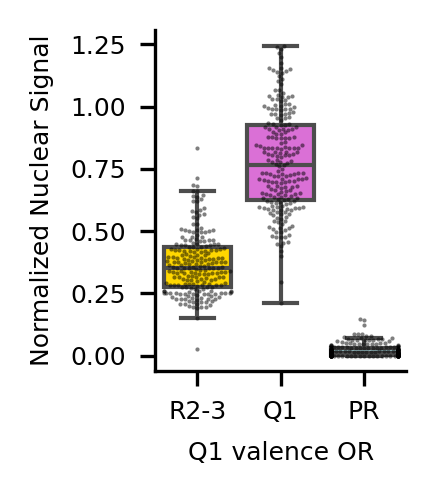

In [479]:
valence_channel = "Q1 valence OR"
channels_to_plot = ["R2-3", "Q1", "PR"]
plot_colors = ['gold', 'orchid', 'powderblue']
f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Normalized Nuclear Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-norm-nuc.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

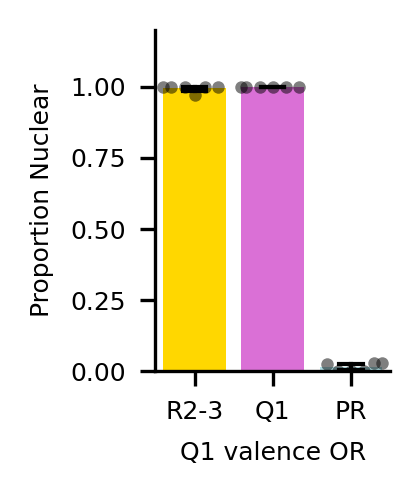

In [480]:
valence_channel = "Q1 valence OR"
channels_to_plot = ["R2-3", "Q1", "PR"]
plot_colors = ['gold', 'orchid', 'powderblue']
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['nuc-norm'] > nuc_norm_threshold)).sum()).reset_index(name='nuclear')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['nuc-norm'].count().values
results_thresholded['prop-nuclear'] = results_thresholded['nuclear'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Nuclear", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-nuclear-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

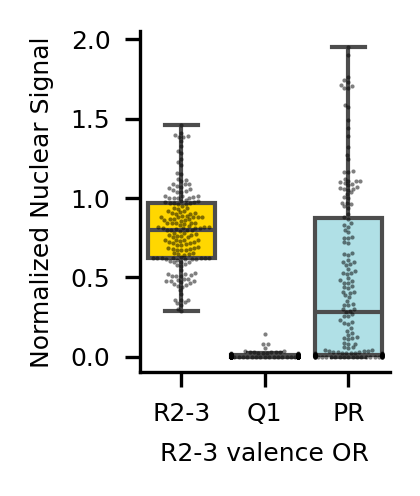

In [481]:
valence_channel = "R2-3 valence OR"
channels_to_plot = ["R2-3", "Q1", "PR"]
plot_colors = ['gold', 'orchid', 'powderblue']
f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Normalized Nuclear Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-norm-nuc.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

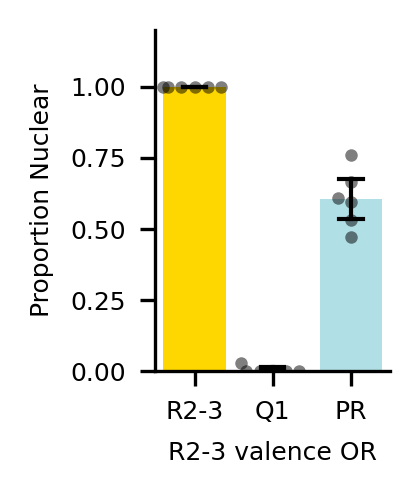

In [482]:
valence_channel = "R2-3 valence OR"
channels_to_plot = ["R2-3", "Q1", "PR"]
plot_colors = ['gold', 'orchid', 'powderblue']
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['nuc-norm'] > nuc_norm_threshold)).sum()).reset_index(name='nuclear')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['nuc-norm'].count().values
results_thresholded['prop-nuclear'] = results_thresholded['nuclear'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Nuclear", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-nuclear-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

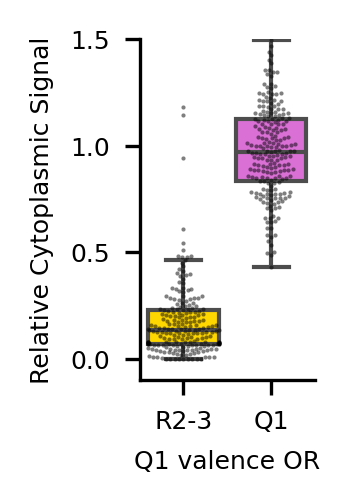

In [483]:
valence_channel = "Q1 valence OR"
channels_to_plot = ["R2-3", "Q1"]
plot_colors = ['gold', 'orchid']
f, ax = plt.subplots(1, 1, figsize=(1.25, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="cyto-prop", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="cyto-prop", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Relative Cytoplasmic Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(-0.1, 1.5)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-rel-cyto.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

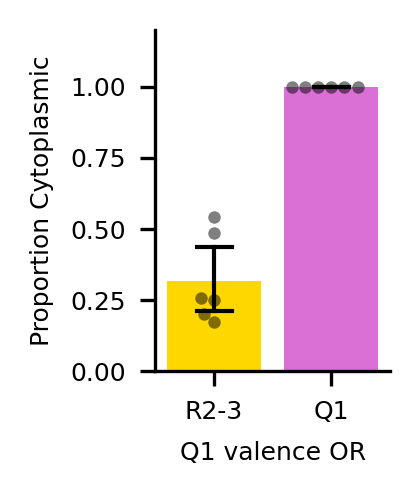

In [484]:
valence_channel = "Q1 valence OR"
channels_to_plot = ["R2-3", "Q1"]
plot_colors = ['gold', 'orchid']
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['cyto-prop'] > cyto_prop_threshold) & (x['nuc-norm'] > nuc_norm_threshold)).sum()).reset_index(name='cytoplasmic')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['cyto-prop'].count().values
results_thresholded['prop-cytoplasmic'] = results_thresholded['cytoplasmic'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Cytoplasmic", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-cyto-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

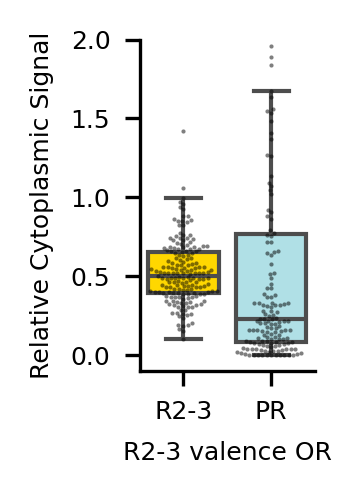

In [485]:
valence_channel = "R2-3 valence OR"
channels_to_plot = ["R2-3", "PR"]
f, ax = plt.subplots(1, 1, figsize=(1.25, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="cyto-prop", ax=ax, palette=['gold', 'powderblue'], order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="cyto-prop", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Relative Cytoplasmic Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(-0.1, 2)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-r2-cyto-pr-rel-cyto.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

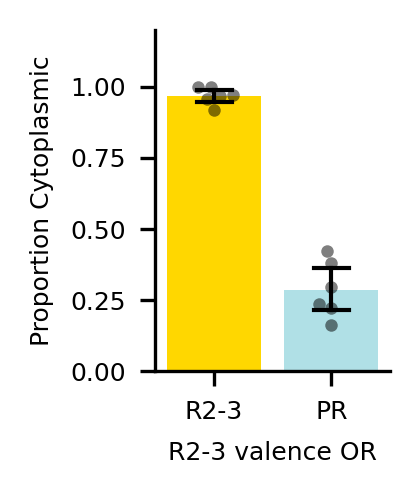

In [486]:
valence_channel = "R2-3 valence OR"
channels_to_plot = ["R2-3", "PR"]
plot_colors = ['gold', 'powderblue']
cyto_prop_threshold = 0.2
nuc_norm_threshold = 0.1
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['cyto-prop'] > cyto_prop_threshold) & (x['nuc-norm'] > nuc_norm_threshold)).sum()).reset_index(name='cytoplasmic')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['cyto-prop'].count().values
results_thresholded['prop-cytoplasmic'] = results_thresholded['cytoplasmic'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Cytoplasmic", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-cyto-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

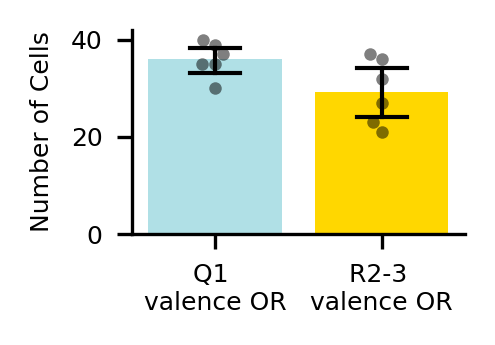

In [487]:
# Plot the number of cells 
valence_counts = results_melted.groupby(['image', 'valence_OR_name']).size().reset_index(name='num_cells')
valence_counts['num_cells'] = valence_counts['num_cells'] / len(results_melted['channel'].unique())
valence_counts['valence_OR_name'] = valence_counts['valence_OR_name'].str.replace('valence OR', '\nvalence OR')
f, ax = plt.subplots(1, 1, figsize=(1.75, 1.25), dpi = 300) 
sns.barplot(data=valence_counts, x="valence_OR_name", y="num_cells", ax=ax, palette=['powderblue', 'gold'], saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=valence_counts, x="valence_OR_name", y="num_cells", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"", fontsize=6)
ax.set_ylabel("Number of Cells", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-cell-counts.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

In [ ]:
file_number = 0 
results_files = os.listdir(f'../../../RNA-FISH-raw-data/{input}')
image = results_files[file_number].replace(".csv", ".czi")
image_path = f'../../../RNA-FISH-raw-data/{input}/{image}'
reader = napari_get_reader(image_path)
if reader is not None:
    layer_data = reader(image_path)
    image_data, metadata, layer_type = layer_data[0]
    print(f"Loaded {image_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

# Load ROIs 
all_rois_path = f'../results/{input}/{image.replace(".czi", "_rois.npy")}'
all_rois = np.load(all_rois_path)
print(f"Loaded {all_rois_path}")

# Load cell_borders 
cell_borders_path = f'../results/{input}/{image.replace(".czi", "_cell_borders.npy")}'
cell_borders = np.load(cell_borders_path)
print(f"Loaded {cell_borders_path}")

Loaded ../raw-data/20250328 2 P14 R2-b3-488 Q1-b1-546 Lnc6-b2-647 DAPI/20250328 2 Q1lnc sample 6.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 0.0, 0.0), 'scale': (1.0, 1.0, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF546-T1', 'AF488-T2', 'DAPI-T3', 'AF647-T3']}
Image shape: (1, 103, 4, 2048, 2048)
Loaded ../results/20250328 2 P14 R2-b3-488 Q1-b1-546 Lnc6-b2-647 DAPI/20250328 2 Q1lnc sample 6_rois.npy
Loaded ../results/20250328 2 P14 R2-b3-488 Q1-b1-546 Lnc6-b2-647 DAPI/20250328 2 Q1lnc sample 6_cell_borders.npy


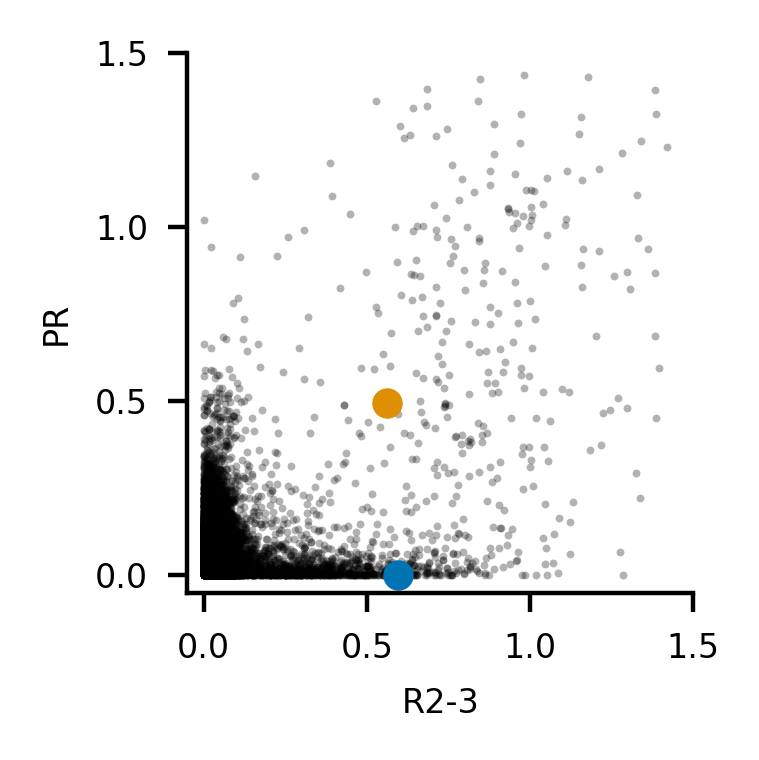

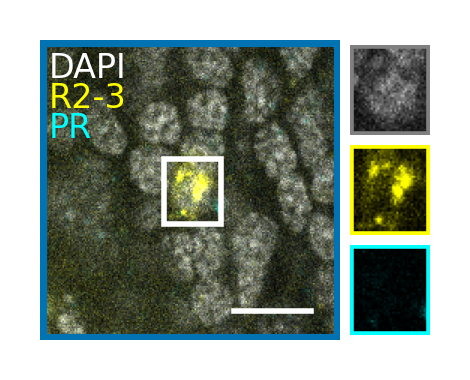

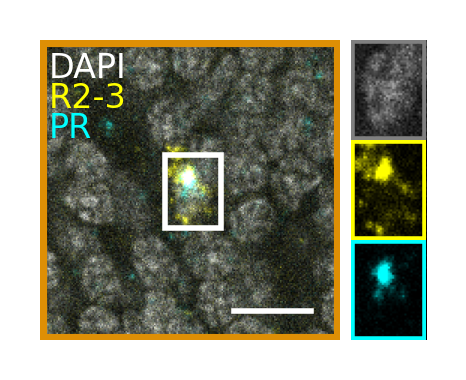

In [489]:
# R2-b3-488 Q1-b1-546 Lnc6-b2-647
plot_2_channels(results=results, image=image_data, metadata=metadata, 
                all_rois=all_rois, cell_borders=cell_borders, input=input, file=image, 
                c1="AF488-nuc-norm", c2="AF647-nuc-norm", 
                c1_name="R2-3", c2_name="PR",
                c1_color="yellow", c2_color="cyan",
                coordinates=[[0.6, 0], [0.6, 0.6]],
                dapi_max=255, c1_max=150, c2_max=150)

## 9E198

In [566]:
input = '9e198'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')
# Load the results 
results_dir = f'../results/{input}'
results_path = os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv')
results = pd.read_csv(results_path)

Using 20250325 6 9e198-b3-488 9e197-b1-546 9e196-b2-647 dapi as input directory


In [567]:
figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)
# Clear directory of files and subdirectories 
for f in os.listdir(figure_dir):
    if os.path.isfile(os.path.join(figure_dir, f)):
        os.remove(os.path.join(figure_dir, f))
    elif os.path.isdir(os.path.join(figure_dir, f)):
        for subf in os.listdir(os.path.join(figure_dir, f)):
            os.remove(os.path.join(figure_dir, f, subf))
        os.rmdir(os.path.join(figure_dir, f))

In [568]:
channels = ['AF488', 'AF546', 'AF647']
channel_names = ["9E198", "9E197", "9E196"]
channel_colors = ["yellow", "magenta", "cyan"]
channel_maxs = [255, 255, 255]

In [569]:
# Normalize the nucleus mean signal for each channel and each image 
for channel in channels: 
    for image in results['image'].unique(): 
        nucleus_mean_signal = results.loc[results['image'] == image][f'{channel}-nucleus-mean'].values
        lower = np.quantile(nucleus_mean_signal, quantile)
        upper = np.quantile(nucleus_mean_signal, 1 - quantile)
        normalized = (nucleus_mean_signal - lower) / (upper - lower)
        results.loc[results['image'] == image, f'{channel}-nuc-norm'] = normalized

In [570]:
# Get the relative cytoplasmic intensity 
for channel in channels: 
    results[f'{channel}-cyto-prop'] = results[f'{channel}-cyto-mean'] / (results[f'{channel}-nucleus-mean'])

In [571]:
# Get only the cytoplasmic results
results_valence = results[results['cytoplasmic'].notnull()]

# Melt results_thresholded, grouping by image and cytoplasmic, for cytoplasm
results_melted_cyto = results_valence.melt(id_vars=['image', 'z', 'z_id', 'cytoplasmic', 'border_pxls'],
                                               value_vars=[c+"-cyto-prop" for c in channels],
                                               var_name='channel', 
                                               value_name='cyto-prop')
results_melted_cyto['channel'] = results_melted_cyto['channel'].str.replace('-cyto-prop', '')

# Melt results_thresholded, grouping by image and cytoplasmic, for nucleus
results_melted_nucleus = results_valence.melt(id_vars=['image', 'z', 'z_id', 'cytoplasmic', 'border_pxls'],
                                               value_vars=[c+"-nuc-norm" for c in channels],
                                               var_name='channel', 
                                               value_name='nuc-norm')
results_melted_nucleus['channel'] = results_melted_nucleus['channel'].str.replace('-nuc-norm', '')

# Combine the two melted dataframes
results_melted = pd.merge(results_melted_cyto, results_melted_nucleus, on=['image', 'z', 'z_id', 'cytoplasmic', 'channel', 'border_pxls'])
results_melted['channel_name'] = results_melted['channel'].map(dict(zip(channels, channel_names)))
results_melted['valence_OR_name'] = results_melted['cytoplasmic'].map(dict(zip(channels, channel_names)))
results_melted['valence_OR_name'] = results_melted['valence_OR_name'] + " valence OR"

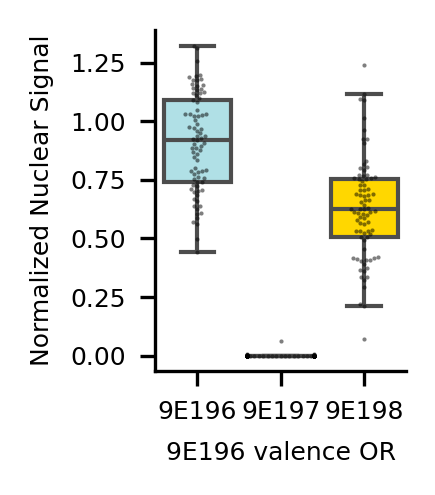

In [572]:
valence_channel = "9E196 valence OR"
channels_to_plot = ["9E196", "9E197", "9E198"]
f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, palette=['powderblue', 'orchid', 'gold'], order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Normalized Nuclear Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-norm-nuc.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

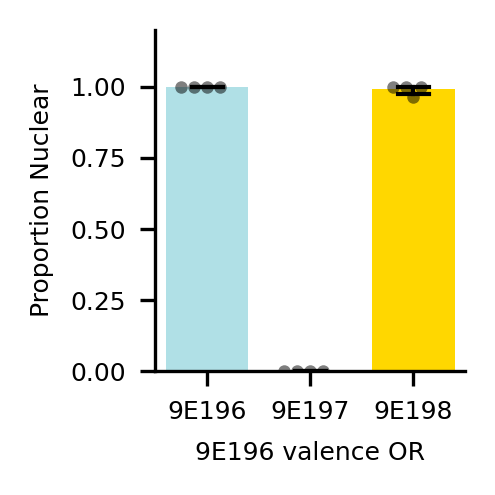

In [573]:
valence_channel = "9E196 valence OR"
channels_to_plot = ["9E196", "9E197", "9E198"]
plot_colors = ['powderblue', 'orchid', 'gold']
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['nuc-norm'] > nuc_norm_threshold)).sum()).reset_index(name='nuclear')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['nuc-norm'].count().values
results_thresholded['prop-nuclear'] = results_thresholded['nuclear'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.75, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Nuclear", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-nuclear-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

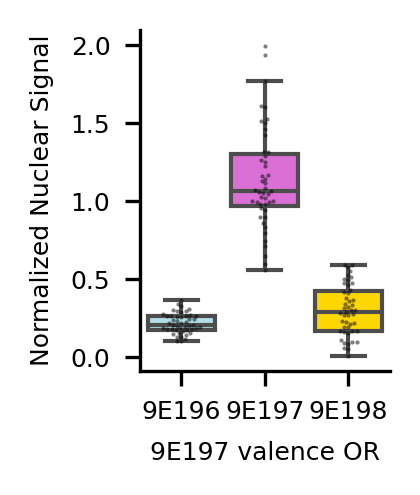

In [574]:
valence_channel = "9E197 valence OR"
channels_to_plot = ["9E196", "9E197", "9E198"]
f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, palette=['powderblue', 'orchid', 'gold'], order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Normalized Nuclear Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-norm-nuc.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

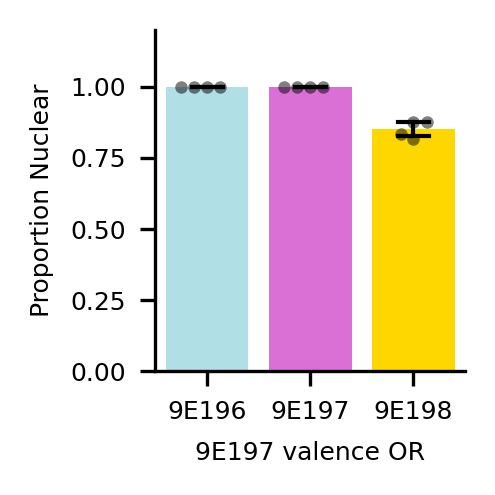

In [575]:
valence_channel = "9E197 valence OR"
channels_to_plot = ["9E196", "9E197", "9E198"]
plot_colors = ['powderblue', 'orchid', 'gold']
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['nuc-norm'] > nuc_norm_threshold)).sum()).reset_index(name='nuclear')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['nuc-norm'].count().values
results_thresholded['prop-nuclear'] = results_thresholded['nuclear'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.75, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Nuclear", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-nuclear-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

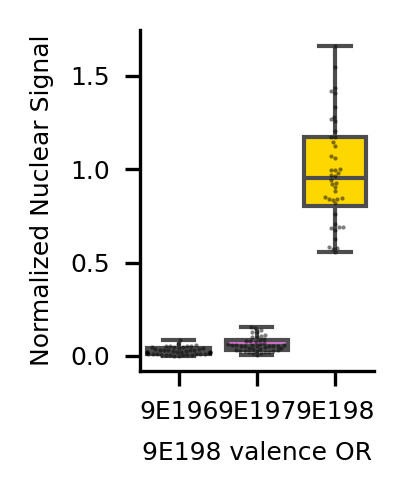

In [576]:
valence_channel = "9E198 valence OR"
channels_to_plot = ["9E196", "9E197", "9E198"]
f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, palette=['powderblue', 'orchid', 'gold'], order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Normalized Nuclear Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-norm-nuc.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

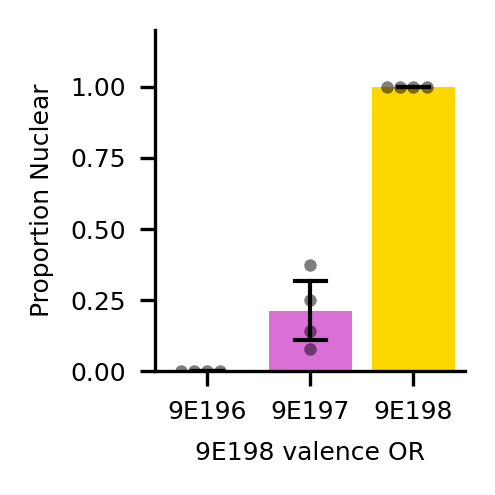

In [577]:
valence_channel = "9E198 valence OR"
channels_to_plot = ["9E196", "9E197", "9E198"]
plot_colors = ['powderblue', 'orchid', 'gold']
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['nuc-norm'] > nuc_norm_threshold)).sum()).reset_index(name='nuclear')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['nuc-norm'].count().values
results_thresholded['prop-nuclear'] = results_thresholded['nuclear'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.75, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Nuclear", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-nuclear-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

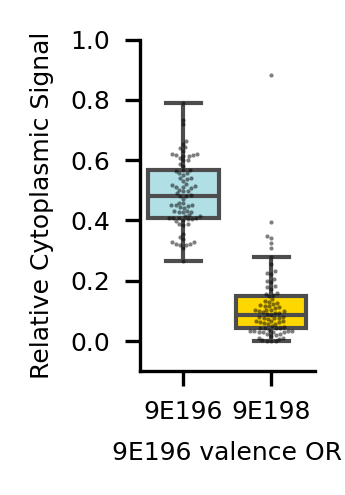

In [578]:
valence_channel = "9E196 valence OR"
channels_to_plot = ["9E196", "9E198"]
f, ax = plt.subplots(1, 1, figsize=(1.25, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="cyto-prop", ax=ax, palette=['powderblue', 'gold'], order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="cyto-prop", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Relative Cytoplasmic Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(-0.1, 1)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-rel-cyto.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

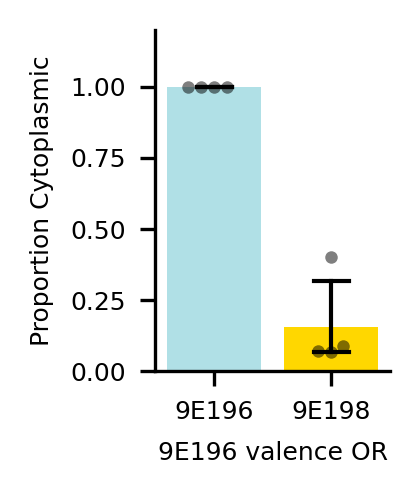

In [579]:
valence_channel = "9E196 valence OR"
channels_to_plot = ["9E196", "9E198"]
plot_colors = ['powderblue', 'gold']
cyto_prop_threshold = 0.2 
nuc_norm_threshold = 0.1
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['cyto-prop'] > cyto_prop_threshold) & (x['nuc-norm'] > nuc_norm_threshold)).sum()).reset_index(name='cytoplasmic')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['cyto-prop'].count().values
results_thresholded['prop-cytoplasmic'] = results_thresholded['cytoplasmic'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Cytoplasmic", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-cyto-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

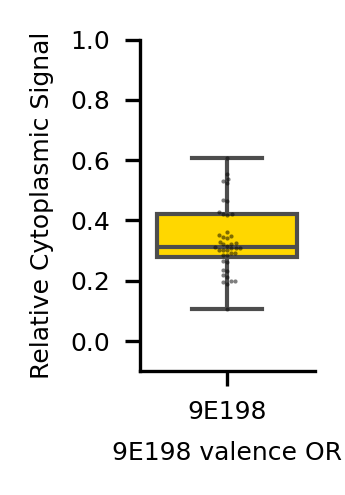

In [580]:
valence_channel = "9E198 valence OR"
channels_to_plot = ["9E198"]
f, ax = plt.subplots(1, 1, figsize=(1.25, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="cyto-prop", ax=ax, palette=['gold'], order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="cyto-prop", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Relative Cytoplasmic Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(-0.1, 1)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-rel-cyto.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

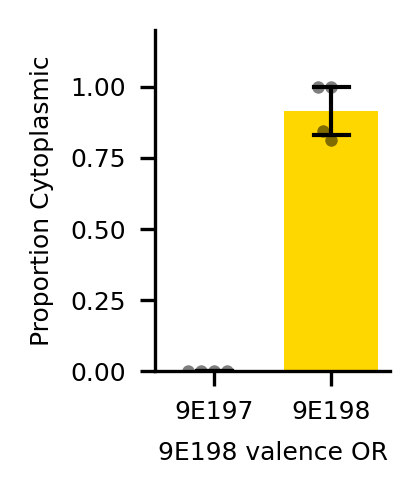

In [583]:
valence_channel = "9E198 valence OR"
channels_to_plot = ["9E197", "9E198"]
plot_colors = ['orchid', 'gold']
cyto_prop_threshold = 0.2 
nuc_norm_threshold = 0.1
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['cyto-prop'] > cyto_prop_threshold) & (x['nuc-norm'] > nuc_norm_threshold)).sum()).reset_index(name='cytoplasmic')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['cyto-prop'].count().values
results_thresholded['prop-cytoplasmic'] = results_thresholded['cytoplasmic'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Cytoplasmic", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-cyto-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

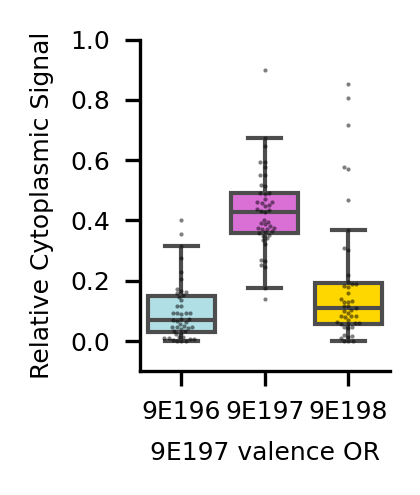

In [506]:
valence_channel = "9E197 valence OR"
channels_to_plot = ["9E196", "9E197", "9E198"]
f, ax = plt.subplots(1, 1, figsize=(1.5, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="cyto-prop", ax=ax, palette=['powderblue', 'orchid', 'gold'], order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="cyto-prop", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Relative Cytoplasmic Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(-0.1, 1)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-rel-cyto.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

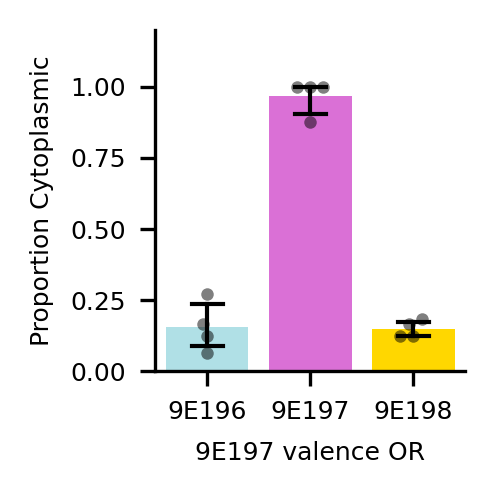

In [507]:
valence_channel = "9E197 valence OR"
channels_to_plot = ["9E196", "9E197", "9E198"]
plot_colors = ['powderblue', 'orchid', 'gold']
cyto_prop_threshold = 0.2 
nuc_norm_threshold = 0.1
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['cyto-prop'] > cyto_prop_threshold) & (x['nuc-norm'] > nuc_norm_threshold)).sum()).reset_index(name='cytoplasmic')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['cyto-prop'].count().values
results_thresholded['prop-cytoplasmic'] = results_thresholded['cytoplasmic'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.75, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Cytoplasmic", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-cyto-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

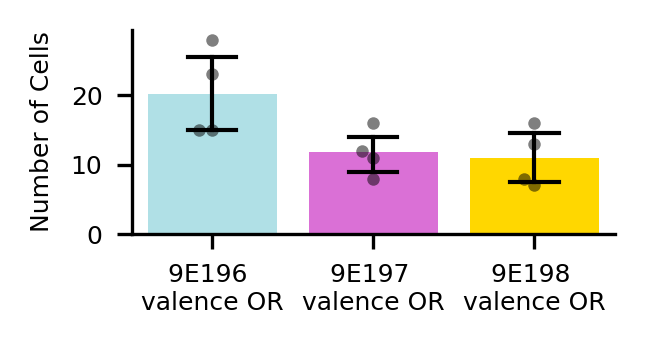

In [508]:
# Plot the number of cells 
valence_counts = results_melted.groupby(['image', 'valence_OR_name']).size().reset_index(name='num_cells')
valence_counts['num_cells'] = valence_counts['num_cells'] / len(results_melted['channel'].unique())
valence_counts['valence_OR_name'] = valence_counts['valence_OR_name'].str.replace('valence OR', '\nvalence OR')
f, ax = plt.subplots(1, 1, figsize=(2.25, 1.25), dpi = 300) 
sns.barplot(data=valence_counts, x="valence_OR_name", y="num_cells", ax=ax, palette=['powderblue', 'orchid', 'gold'], saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=valence_counts, x="valence_OR_name", y="num_cells", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"", fontsize=6)
ax.set_ylabel("Number of Cells", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-cell-counts.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

In [ ]:
file_number = 1
results_files = os.listdir(f'../../../RNA-FISH-raw-data/{input}')
image = results_files[file_number].replace(".csv", ".czi")
image_path = f'../../../RNA-FISH-raw-data/{input}/{image}'
reader = napari_get_reader(image_path)
if reader is not None:
    layer_data = reader(image_path)
    image_data, metadata, layer_type = layer_data[0]
    print(f"Loaded {image_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

# Load ROIs 
all_rois_path = f'../results/{input}/{image.replace(".czi", "_rois.npy")}'
all_rois = np.load(all_rois_path)
print(f"Loaded {all_rois_path}")

# Load cell_borders 
cell_borders_path = f'../results/{input}/{image.replace(".czi", "_cell_borders.npy")}'
cell_borders = np.load(cell_borders_path)
print(f"Loaded {cell_borders_path}")

Loaded ../raw-data/20250325 6 9e198-b3-488 9e197-b1-546 9e196-b2-647 dapi/20250325 5 t35 sample 3 great.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 0.0, 0.0), 'scale': (1.0, 1.0, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF546-T1', 'AF488-T2', 'DAPI-T3', 'AF647-T3']}
Image shape: (1, 102, 4, 2048, 2048)
Loaded ../results/20250325 6 9e198-b3-488 9e197-b1-546 9e196-b2-647 dapi/20250325 5 t35 sample 3 great_rois.npy
Loaded ../results/20250325 6 9e198-b3-488 9e197-b1-546 9e196-b2-647 dapi/20250325 5 t35 sample 3 great_cell_borders.npy


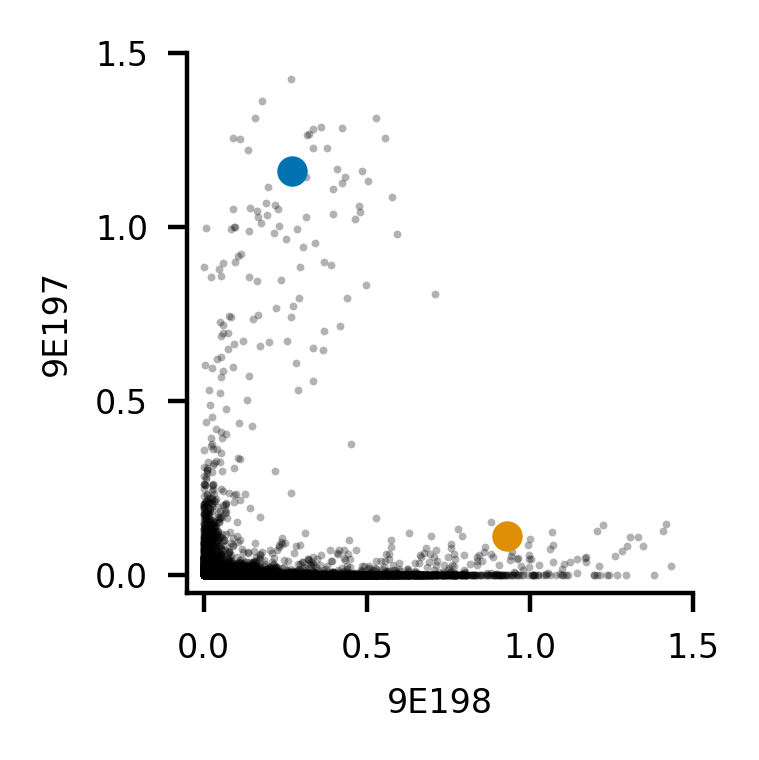

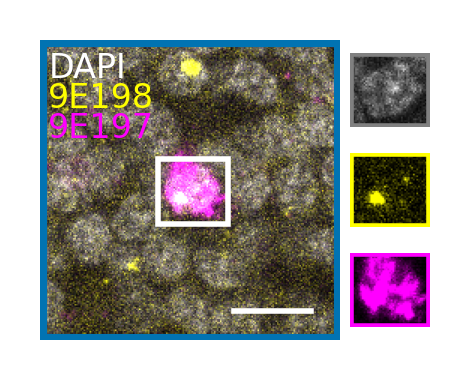

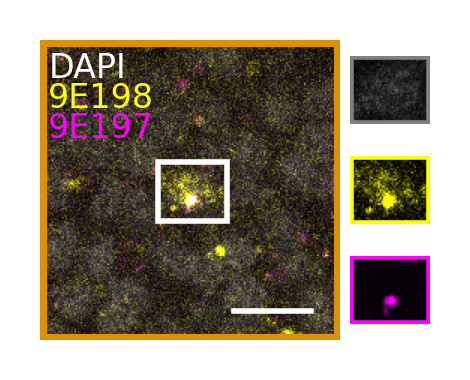

In [586]:
# 9e198-b3-488 9e197-b1-546 9e196-b2-647
plot_2_channels(results=results, image=image_data, metadata=metadata, 
                all_rois=all_rois, cell_borders=cell_borders, input=input, file=image, 
                c1="AF488-nuc-norm", c2="AF546-nuc-norm", 
                c1_name="9E198", c2_name="9E197",
                c1_color="yellow", c2_color="magenta",
                coordinates=[[0.3, 1.2], [0.95, 0.2]],
                dapi_max=255, c1_max=50, c2_max=50)

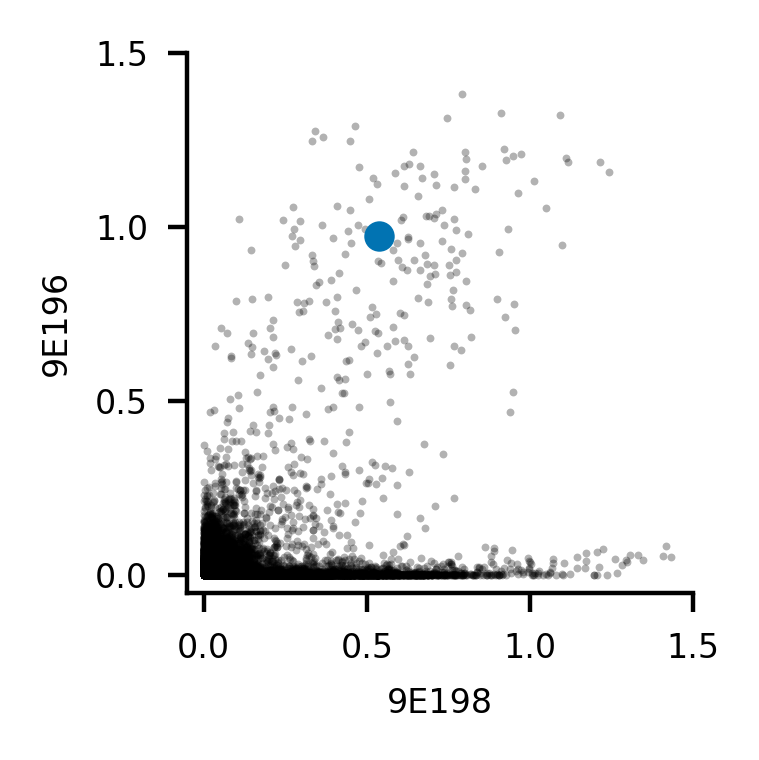

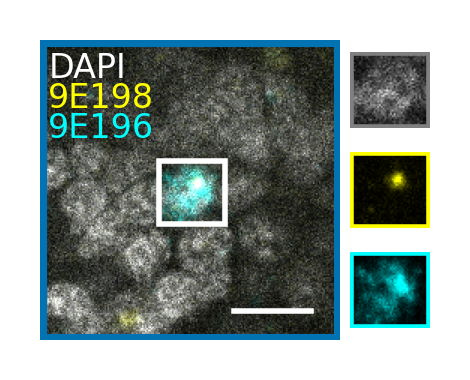

In [590]:
# 9e198-b3-488 9e197-b1-546 9e196-b2-647
plot_2_channels(results=results, image=image_data, metadata=metadata, 
                all_rois=all_rois, cell_borders=cell_borders, input=input, file=image, 
                c1="AF488-nuc-norm", c2="AF647-nuc-norm", 
                c1_name="9E198", c2_name="9E196",
                c1_color="yellow", c2_color="cyan",
                coordinates=[[0.5, 1]],
                dapi_max=150, c1_max=255, c2_max=255)

## LOC104 & 9E129

In [511]:
input = '9E129'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')
# Load the results 
results_dir = f'../results/{input}'
results_path = os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv')
results = pd.read_csv(results_path)

Using 20250328 4 P14 9E129-b3-488 LOC104-b1-546 9E116-b2-647 dapi as input directory


In [512]:
figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)
# Clear directory of files and subdirectories 
for f in os.listdir(figure_dir):
    if os.path.isfile(os.path.join(figure_dir, f)):
        os.remove(os.path.join(figure_dir, f))
    elif os.path.isdir(os.path.join(figure_dir, f)):
        for subf in os.listdir(os.path.join(figure_dir, f)):
            os.remove(os.path.join(figure_dir, f, subf))
        os.rmdir(os.path.join(figure_dir, f))

In [513]:
channels = ['AF488', 'AF546', 'AF647']
channel_names = ["9E129", "LOC105275104", "9E116"]
channel_colors = ["yellow", "magenta", "cyan"]
channel_maxs = [255, 255, 255]

In [514]:
# Normalize the nucleus mean signal for each channel and each image 
for channel in channels: 
    for image in results['image'].unique(): 
        nucleus_mean_signal = results.loc[results['image'] == image][f'{channel}-nucleus-mean'].values
        lower = np.quantile(nucleus_mean_signal, quantile)
        upper = np.quantile(nucleus_mean_signal, 1 - quantile)
        normalized = (nucleus_mean_signal - lower) / (upper - lower)
        results.loc[results['image'] == image, f'{channel}-nuc-norm'] = normalized

In [515]:
# Get the relative cytoplasmic intensity 
for channel in channels: 
    results[f'{channel}-cyto-prop'] = results[f'{channel}-cyto-mean'] / (results[f'{channel}-nucleus-mean'])

In [516]:
# Get only the cytoplasmic results
results_valence = results[results['cytoplasmic'].notnull()]

# Melt results_thresholded, grouping by image and cytoplasmic, for cytoplasm
results_melted_cyto = results_valence.melt(id_vars=['image', 'z', 'z_id', 'cytoplasmic', 'border_pxls'],
                                               value_vars=[c+"-cyto-prop" for c in channels],
                                               var_name='channel', 
                                               value_name='cyto-prop')
results_melted_cyto['channel'] = results_melted_cyto['channel'].str.replace('-cyto-prop', '')

# Melt results_thresholded, grouping by image and cytoplasmic, for nucleus
results_melted_nucleus = results_valence.melt(id_vars=['image', 'z', 'z_id', 'cytoplasmic', 'border_pxls'],
                                               value_vars=[c+"-nuc-norm" for c in channels],
                                               var_name='channel', 
                                               value_name='nuc-norm')
results_melted_nucleus['channel'] = results_melted_nucleus['channel'].str.replace('-nuc-norm', '')

# Combine the two melted dataframes
results_melted = pd.merge(results_melted_cyto, results_melted_nucleus, on=['image', 'z', 'z_id', 'cytoplasmic', 'channel', 'border_pxls'])
results_melted['channel_name'] = results_melted['channel'].map(dict(zip(channels, channel_names)))
results_melted['valence_OR_name'] = results_melted['cytoplasmic'].map(dict(zip(channels, channel_names)))
results_melted['valence_OR_name'] = results_melted['valence_OR_name'] + " valence OR"

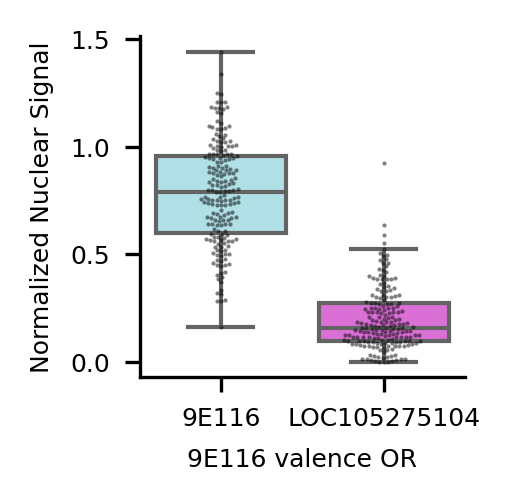

In [517]:
valence_channel = "9E116 valence OR"
channels_to_plot = ["9E116", "LOC105275104"]
f, ax = plt.subplots(1, 1, figsize=(1.75, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, palette=['powderblue', 'orchid'], order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Normalized Nuclear Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-norm-nuc.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

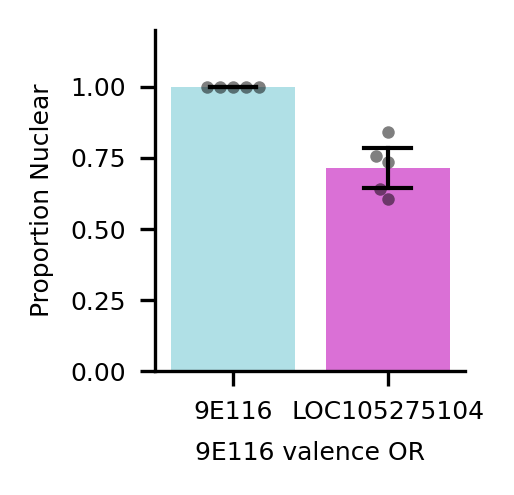

In [518]:
valence_channel = "9E116 valence OR"
channels_to_plot = ["9E116", "LOC105275104"]
plot_colors = ['powderblue', 'orchid', 'gold']
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['nuc-norm'] > nuc_norm_threshold)).sum()).reset_index(name='nuclear')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['nuc-norm'].count().values
results_thresholded['prop-nuclear'] = results_thresholded['nuclear'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.75, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Nuclear", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-nuclear-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

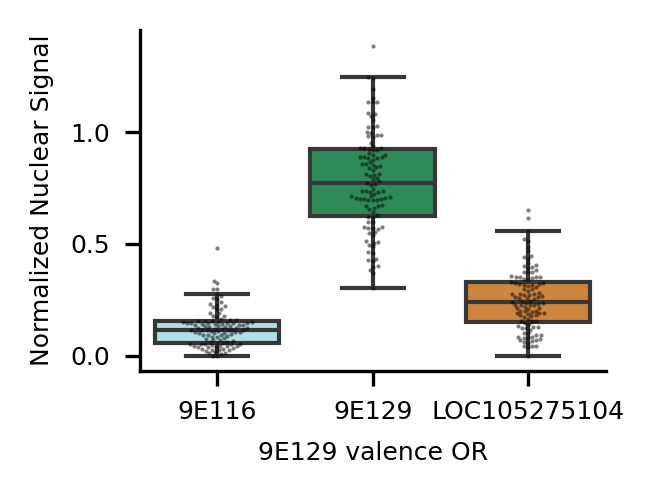

In [519]:
valence_channel = "9E129 valence OR"
channels_to_plot = ["9E116", "9E129", "LOC105275104"]
f, ax = plt.subplots(1, 1, figsize=(2.25, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, palette=['powderblue', 'seagreen', 'peru'], order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Normalized Nuclear Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-norm-nuc.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

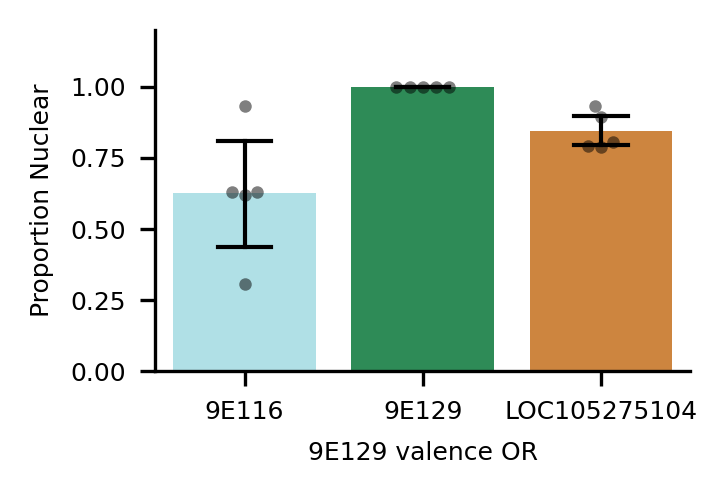

In [520]:
valence_channel = "9E129 valence OR"
channels_to_plot = ["9E116", "9E129", "LOC105275104"]
plot_colors = ['powderblue', 'seagreen', 'peru']
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['nuc-norm'] > nuc_norm_threshold)).sum()).reset_index(name='nuclear')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['nuc-norm'].count().values
results_thresholded['prop-nuclear'] = results_thresholded['nuclear'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(2.5, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Nuclear", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-nuclear-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

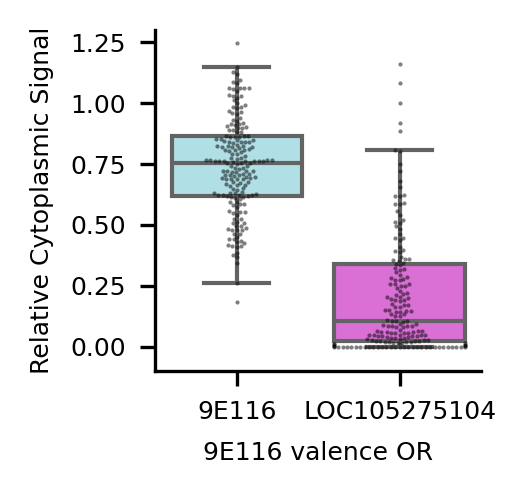

In [521]:
valence_channel = "9E116 valence OR"
channels_to_plot = ["9E116", "LOC105275104"]
f, ax = plt.subplots(1, 1, figsize=(1.75, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="cyto-prop", ax=ax, palette=['powderblue', 'orchid'], order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="cyto-prop", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Relative Cytoplasmic Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(-0.1, 1.3)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-cyto-rel.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

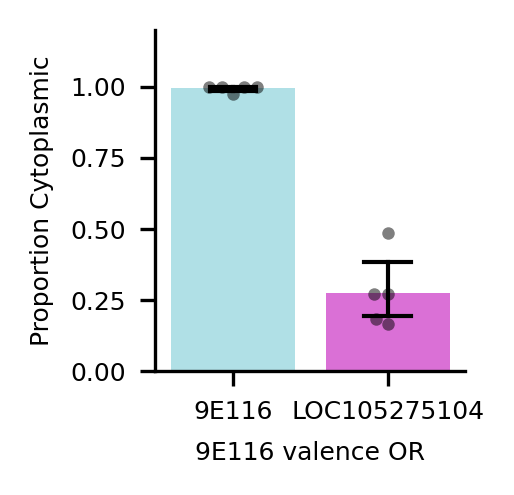

In [522]:
valence_channel = "9E116 valence OR"
channels_to_plot = ["9E116", "LOC105275104"]
plot_colors = ['powderblue', 'orchid']
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['cyto-prop'] > cyto_prop_threshold) & (x['nuc-norm'] > nuc_norm_threshold)).sum()).reset_index(name='cytoplasmic')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['cyto-prop'].count().values
results_thresholded['prop-cytoplasmic'] = results_thresholded['cytoplasmic'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.75, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Cytoplasmic", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-cyto-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

## LOC603 & 9E108

In [523]:
input = 'LOC603'
input = [d for d in raw_data_dirs if input in d][0]
print(f'Using {input} as input directory')
# Load the results 
results_dir = f'../results/{input}'
results_path = os.path.join(results_dir, 'all_results_nuclei_cytoplasm_markers.csv')
results = pd.read_csv(results_path)

Using 20250328 5 P14 LOC603-b3-488 9E108-b1-546 9E116-b2-647 DAPI as input directory


In [524]:
figure_dir = f'../figures/model_B_only_OSNs/{input}'
os.makedirs(f"../figures/model_B_only_OSNs/{input}", exist_ok=True)
# Clear directory of files and subdirectories 
for f in os.listdir(figure_dir):
    if os.path.isfile(os.path.join(figure_dir, f)):
        os.remove(os.path.join(figure_dir, f))
    elif os.path.isdir(os.path.join(figure_dir, f)):
        for subf in os.listdir(os.path.join(figure_dir, f)):
            os.remove(os.path.join(figure_dir, f, subf))
        os.rmdir(os.path.join(figure_dir, f))

In [525]:
channels = ['AF488', 'AF546', 'AF647']
channel_names = ["LOC105282603", "9E108", "9E116"]
channel_colors = ["yellow", "magenta", "cyan"]
channel_maxs = [255, 255, 255]

In [526]:
# Normalize the nucleus mean signal for each channel and each image 
for channel in channels: 
    for image in results['image'].unique(): 
        nucleus_mean_signal = results.loc[results['image'] == image][f'{channel}-nucleus-mean'].values
        lower = np.quantile(nucleus_mean_signal, quantile)
        upper = np.quantile(nucleus_mean_signal, 1 - quantile)
        normalized = (nucleus_mean_signal - lower) / (upper - lower)
        results.loc[results['image'] == image, f'{channel}-nuc-norm'] = normalized

In [527]:
# Get the relative cytoplasmic intensity 
for channel in channels: 
    results[f'{channel}-cyto-prop'] = results[f'{channel}-cyto-mean'] / (results[f'{channel}-nucleus-mean'])

In [528]:
# Get only the cytoplasmic results
results_valence = results[results['cytoplasmic'].notnull()]

# Melt results_thresholded, grouping by image and cytoplasmic, for cytoplasm
results_melted_cyto = results_valence.melt(id_vars=['image', 'z', 'z_id', 'cytoplasmic', 'border_pxls'],
                                               value_vars=[c+"-cyto-prop" for c in channels],
                                               var_name='channel', 
                                               value_name='cyto-prop')
results_melted_cyto['channel'] = results_melted_cyto['channel'].str.replace('-cyto-prop', '')

# Melt results_thresholded, grouping by image and cytoplasmic, for nucleus
results_melted_nucleus = results_valence.melt(id_vars=['image', 'z', 'z_id', 'cytoplasmic', 'border_pxls'],
                                               value_vars=[c+"-nuc-norm" for c in channels],
                                               var_name='channel', 
                                               value_name='nuc-norm')
results_melted_nucleus['channel'] = results_melted_nucleus['channel'].str.replace('-nuc-norm', '')

# Combine the two melted dataframes
results_melted = pd.merge(results_melted_cyto, results_melted_nucleus, on=['image', 'z', 'z_id', 'cytoplasmic', 'channel', 'border_pxls'])
results_melted['channel_name'] = results_melted['channel'].map(dict(zip(channels, channel_names)))
results_melted['valence_OR_name'] = results_melted['cytoplasmic'].map(dict(zip(channels, channel_names)))
results_melted['valence_OR_name'] = results_melted['valence_OR_name'] + " valence OR"

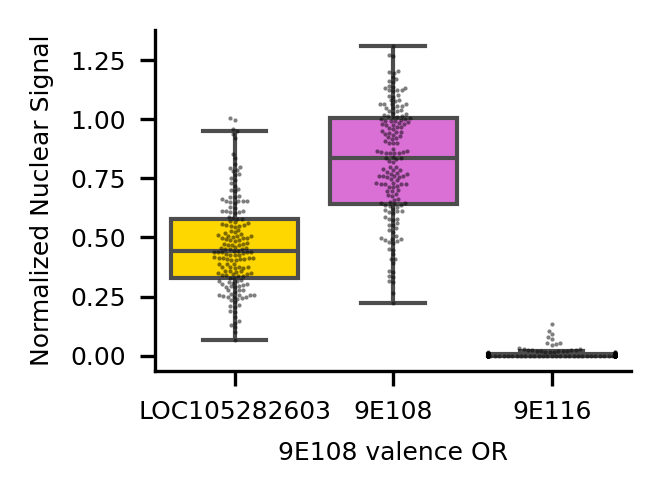

In [529]:
valence_channel = "9E108 valence OR"
channels_to_plot = ["LOC105282603", "9E108", "9E116"]
f, ax = plt.subplots(1, 1, figsize=(2.25, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, palette=['gold', 'orchid', 'powderblue'], order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Normalized Nuclear Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-norm-nuc.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

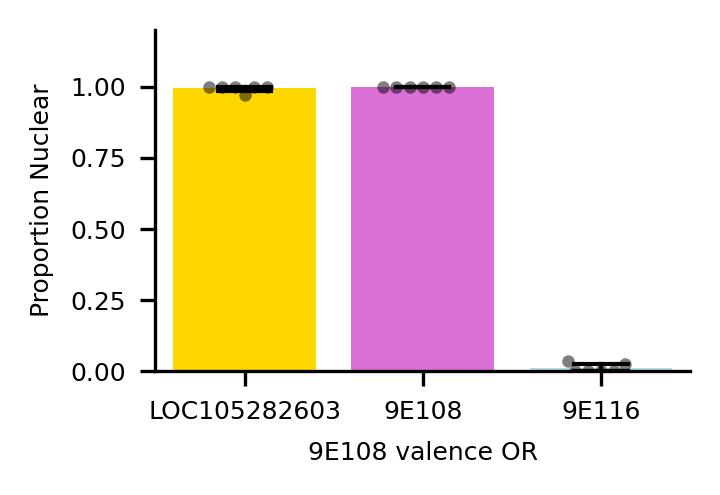

In [530]:
valence_channel = "9E108 valence OR"
channels_to_plot = ["LOC105282603", "9E108", "9E116"]
plot_colors = ['gold', 'orchid', 'powderblue']
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['nuc-norm'] > nuc_norm_threshold)).sum()).reset_index(name='nuclear')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['nuc-norm'].count().values
results_thresholded['prop-nuclear'] = results_thresholded['nuclear'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(2.5, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Nuclear", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-nuclear-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

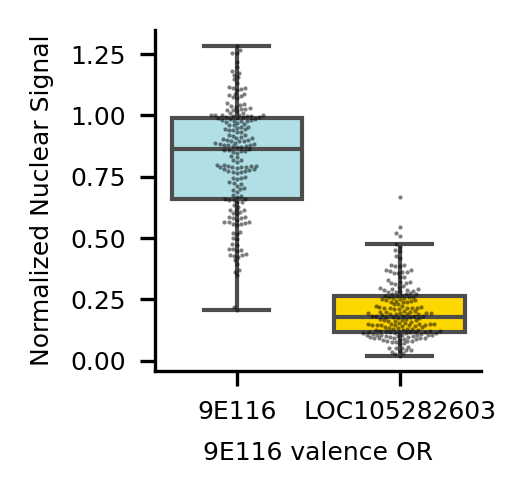

In [531]:
valence_channel = "9E116 valence OR"
channels_to_plot = ["9E116", "LOC105282603"]
f, ax = plt.subplots(1, 1, figsize=(1.75, 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, palette=['powderblue', 'gold', 'powderblue'], order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="nuc-norm", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Normalized Nuclear Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-norm-nuc.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

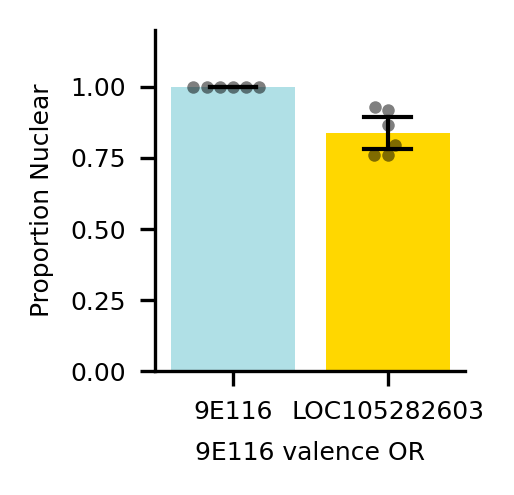

In [532]:
valence_channel = "9E116 valence OR"
channels_to_plot = ["9E116", "LOC105282603"]
plot_colors = ['powderblue', 'gold', 'powderblue']
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['nuc-norm'] > nuc_norm_threshold)).sum()).reset_index(name='nuclear')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['nuc-norm'].count().values
results_thresholded['prop-nuclear'] = results_thresholded['nuclear'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.75, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-nuclear", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Nuclear", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-nuclear-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

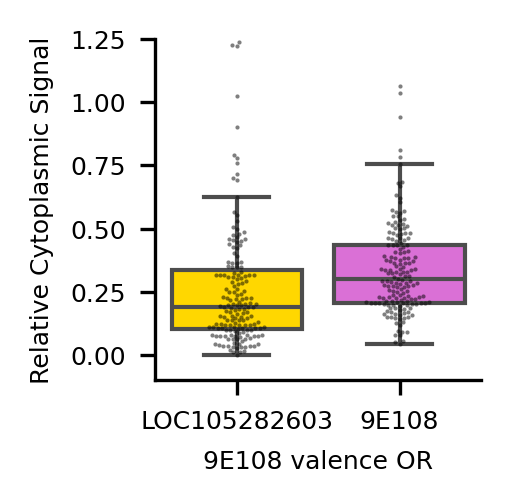

In [533]:
valence_channel = "9E108 valence OR"
channels_to_plot = ["LOC105282603", "9E108"]
f, ax = plt.subplots(1, 1, figsize=(1.75 , 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="cyto-prop", ax=ax, palette=['gold', 'orchid'], order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="cyto-prop", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Relative Cytoplasmic Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(-0.1, 1.25)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-rel-cyto.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

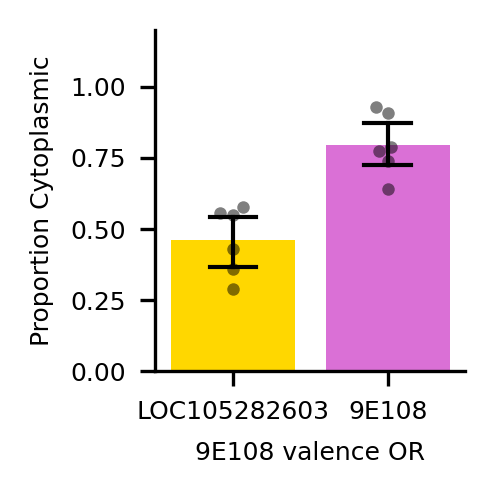

In [534]:
valence_channel = "9E108 valence OR"
channels_to_plot = ["LOC105282603", "9E108"]
plot_colors = ['gold', 'orchid']
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['cyto-prop'] > cyto_prop_threshold) & (x['nuc-norm'] > nuc_norm_threshold)).sum()).reset_index(name='cytoplasmic')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['cyto-prop'].count().values
results_thresholded['prop-cytoplasmic'] = results_thresholded['cytoplasmic'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.75, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Cytoplasmic", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-cyto-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

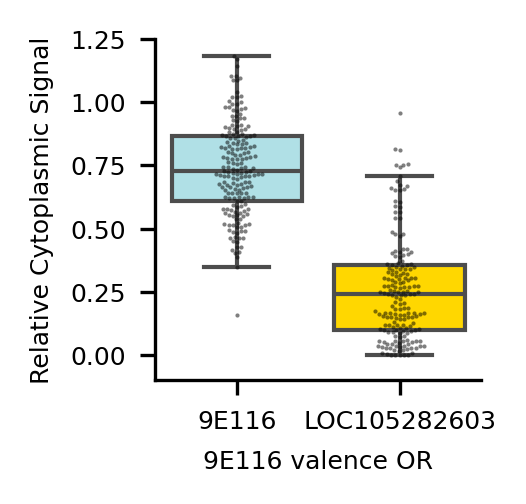

In [535]:
valence_channel = "9E116 valence OR"
channels_to_plot = ["9E116", "LOC105282603"]
f, ax = plt.subplots(1, 1, figsize=(1.75 , 1.75), dpi = 300) 
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
sns.boxplot(data=results_subset, x="channel_name", y="cyto-prop", ax=ax, palette=['powderblue', 'gold'], order=channels_to_plot, saturation=1, showfliers=False)
sns.swarmplot(data=results_subset, x="channel_name", y="cyto-prop", ax=ax, color='black', alpha=0.5, s=1, legend=False, dodge=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Relative Cytoplasmic Signal", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(-0.1, 1.25)
plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-rel-cyto.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

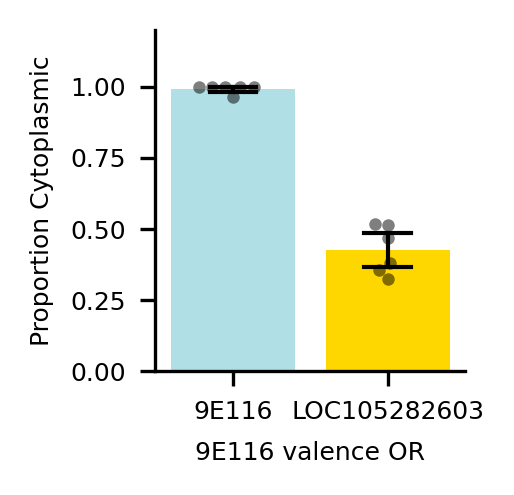

In [536]:
valence_channel = "9E116 valence OR"
channels_to_plot = ["9E116", "LOC105282603"]
plot_colors = ['powderblue', 'gold']
cyto_prop_threshold = 0.2 
nuc_norm_threshold = 0.1
results_subset = results_melted[(results_melted["valence_OR_name"] == valence_channel) & (results_melted["channel_name"].isin(channels_to_plot))]
results_thresholded = results_subset.groupby(['image', 'channel_name']).apply(lambda x: ((x['cyto-prop'] > cyto_prop_threshold) & (x['nuc-norm'] > nuc_norm_threshold)).sum()).reset_index(name='cytoplasmic')
results_thresholded['total_cells'] = results_subset.groupby(['image', 'channel_name'])['cyto-prop'].count().values
results_thresholded['prop-cytoplasmic'] = results_thresholded['cytoplasmic'] / results_thresholded['total_cells']

f, ax = plt.subplots(1, 1, figsize=(1.75, 1.75), dpi = 300) 
sns.barplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, palette=plot_colors, order=channels_to_plot, saturation=1, 
            alpha=1, lw=0, errorbar=("ci", 95), capsize=0.3, errwidth=1, errcolor='black')
sns.swarmplot(data=results_thresholded, x="channel_name", y="prop-cytoplasmic", ax=ax, color='black', alpha=0.5, s=3, legend=False, dodge=True) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel(f"{valence_channel}", fontsize=6)
ax.set_ylabel("Proportion Cytoplasmic", fontsize=6)
ax.tick_params(axis='both', which='major', labelsize=6)
ax.set_ylim(0, 1.2)
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])

plt.tight_layout()
plt.savefig(f"../figures/model_B_only_OSNs/{input}/{input}-{valence_channel}-proportion.pdf", format="pdf", pad_inches=0, bbox_inches=0, transparent=False)

In [ ]:
file_number = 0
results_files = os.listdir(f'../../../RNA-FISH-raw-data/{input}')
image = results_files[file_number].replace(".csv", ".czi")
image_path = f'../../../RNA-FISH-raw-data/{input}/{image}'
reader = napari_get_reader(image_path)
if reader is not None:
    layer_data = reader(image_path)
    image_data, metadata, layer_type = layer_data[0]
    print(f"Loaded {image_path}")
    print("Metadata:", metadata)
    print("Image shape:", image_data.shape)  

# Load ROIs 
all_rois_path = f'../results/{input}/{image.replace(".czi", "_rois.npy")}'
all_rois = np.load(all_rois_path)
print(f"Loaded {all_rois_path}")

# Load cell_borders 
cell_borders_path = f'../results/{input}/{image.replace(".czi", "_cell_borders.npy")}'
cell_borders = np.load(cell_borders_path)
print(f"Loaded {cell_borders_path}")

Loaded ../raw-data/20250328 5 P14 LOC603-b3-488 9E108-b1-546 9E116-b2-647 DAPI/20250328 5 ZP sample 4.czi
Metadata: {'rgb': False, 'channel_axis': 2, 'translate': (0.0, 0.0, 0.0, 0.0), 'scale': (1.0, 1.0, 0.0974884033203125, 0.0974884033203125), 'contrast_limits': None, 'name': ['AF546-T1', 'AF488-T2', 'DAPI-T3', 'AF647-T3']}
Image shape: (1, 85, 4, 2048, 2048)
Loaded ../results/20250328 5 P14 LOC603-b3-488 9E108-b1-546 9E116-b2-647 DAPI/20250328 5 ZP sample 4_rois.npy
Loaded ../results/20250328 5 P14 LOC603-b3-488 9E108-b1-546 9E116-b2-647 DAPI/20250328 5 ZP sample 4_cell_borders.npy


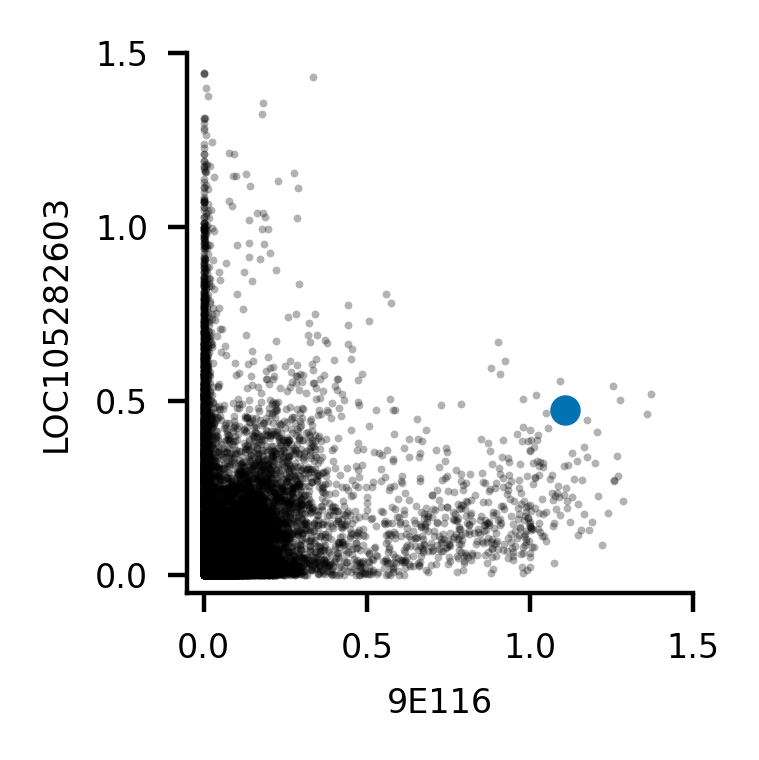

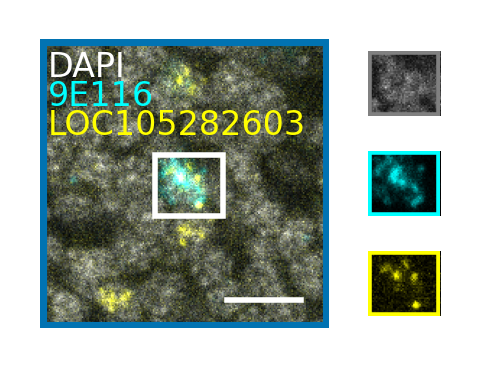

In [538]:
# LOC603-b3-488 9E108-b1-546 9E116-b2-647
plot_2_channels(results=results, image=image_data, metadata=metadata, 
                all_rois=all_rois, cell_borders=cell_borders, input=input, file=image, 
                c1="AF647-nuc-norm", c2="AF488-nuc-norm", 
                c1_name="9E116", c2_name="LOC105282603",
                c1_color="cyan", c2_color="yellow",
                coordinates=[[1.1, 0.4]], bbox_expansion=7, 
                dapi_max=255, c1_max=255, c2_max=100)